# Exercise 3: Supervised Learning with Kernel Methods

The purpose of this exercise is to get familiar with kernel-method based regression (using Kernel Ridge Regression, KRR) and classification of data (using Support-Vector Machine, SVM).

The exercise is structured in two main blocks:
1.   Kernel Ridge Regression for HOMO energy prediction (essential content)
2.   Support-Vector Machine Classification of the majority element in various metal alloys (optional content)

The relevant background of each part of the exercise will be provided in the respective block, so please read the content below carefully.

## 1. HOMO energy prediction with kernel ridge regression


Here we will machine-learn the relationship between molecular structure (represented by the Coulomb matrix CM) and their HOMO (Highest Occupied Molecular Orbital) energy using KRR. Molecular orbitals represent the energy levels of electrons in molecules, and are essential in understanding how molecules adsorb and emit light, so HOMO is a frequent target of machine learning predictions.

As discussed in the lecture, KRR is a machine learning method that performs regression (fitting). This tutorial shows step by step how to load the data, visualize them, select the hyperparameters, train the model and validate it. We use the QM7 dataset of 7000 small organic molecules. The HOMO energies of all molecules were pre-computed with first principles quantum mechanical methods (DFT) to obtain the target data that our model can be trained on. Detailed descriptions and results for a similar dataset (QM9) can be found in [A. Stuke, et al. "Chemical diversity in molecular orbital energy predictions with kernel ridge regression." J. Chem. Phys. 150. 204121 (2019)](https://aip.scitation.org/doi/10.1063/1.5086105).


## Setup

In [ ]:
# Let's load here all the necessary functions for KRR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

# And now let's load the requisite Python pacakges
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import math, random
from scipy.sparse import load_npz
from matplotlib.colors import LinearSegmentedColormap
import time

### Load and visualize data

At first, we load the molecular dataset.

The input data x is an array that contains all 7000 molecules of the QM7 dataset, represented by their Coulomb matrices, which were computed with the [Dscribe](https://www.sciencedirect.com/science/article/pii/S0010465519303042?via%3Dihub) package.

The output data y is a list that contains the corresponding (pre-computed) HOMO energies.

In [ ]:
!wget https://github.com/fullmetalfelix/ML-CSC-tutorial/raw/master/data/qm7/cm.npz
!wget https://raw.githubusercontent.com/fullmetalfelix/ML-CSC-tutorial/master/data/qm7/HOMO.txt

In [ ]:
x = load_npz("cm.npz").toarray()
y = np.genfromtxt("HOMO.txt")

print("Number of molecules:", len(y))

Print the Coulomb matrix of a random molecule in the dataset.

In [ ]:
rand_mol = random.randint(0, len(y))

print(x[rand_mol])

Visualize the Coulomb matrix of the random molecule.

In [ ]:
shape = (23, 23)
mat = x[rand_mol].reshape(shape)

plt.figure()
plt.figure(figsize = (6,6))
plt.imshow(mat, origin="upper", cmap='rainbow', vmin=-15, vmax=90, interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=20)
plt.axis('off')
plt.show()

Note that many of the outputs are zero in the Coulomb matrix. This is because the size of the Coulomb matrix must be the same for each data entry. Consequently, the size is set according to the largest molecule in the dataset, and for smaller molecules the Coulomb matrix is zero-padded (the remaining empty matrix entries are set to zero).

Next, visualize the target data by plotting the distribution of HOMO energies in the dataset. What kind of a distribution is this?

In [ ]:
plt.hist(y, bins=20, density=False, facecolor='blue')
plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.title("Distribution of HOMO energies")
plt.show()

## mean value of distribution
print("Mean value of HOMO energies in QM7 dataset: %0.2f eV" %np.mean(y))

Before dividing the dataset into training and test set, we shuffle the data. This is because data are often stored in a logical order (e.g., certain types of molecules grouped one after each other). Simply taking the first part for training and the second for testing would not result in a well trained model, since the training set would not represent the test data well (and vice versa).

In [ ]:
## shuffle the data

c = list(zip(x, y))
random.shuffle(c)

x, y = zip(*c)

x = np.array(x)
y = np.array(y)

Now, we divide the data into training and test set. Select 1000 molecules for both your training and test set.

In [ ]:
# define how many samples to take from the database for training and testing
n_train = 1000
n_test = 1000

# split data in training and test for both X and Y
# take first n_train molecules for training
x_train  = x[0:n_train]
y_train = y[0:n_train]

# take the next n_test data for testing
x_test = x[n_train:n_train + n_test]
y_test = y[n_train:n_train + n_test]

Check that the training data resemble the test data well by plotting the distribution of HOMO energies for both sets.

In [ ]:
# plot the training and test set labels Y
plt.hist(y_train, bins=20, density=False, alpha=0.5, facecolor='red', label='test set')
plt.hist(y_test, bins=20, density=False, alpha=0.5, facecolor='gray', label='training set')

plt.xlabel("Energy [eV]")
plt.ylabel("Number of molecules")
plt.legend()
plt.show()

The training and test set distributions should be centered around the same mean value and have the same shape as the complete dataset. Print out the values below to check:

In [ ]:
## mean value of distributions
print("Mean value of HOMO energies in training set: %0.2f eV" %np.mean(y_train))
print("Mean value of HOMO energies in test set: %0.2f eV" %np.mean(y_test))

### Training

In the training phase we use a kernel function to measure the distance between all pairs of molecules (represented by their Coulomb matrices) in the training set. We here employ one of two kernels, the Gaussian kernel or the Laplacian kernel. Both kernels have two hyperparameters: $\alpha$ controls the penalty term and $\gamma$ the kernel width.

To find the optimal hyperparameters, we will do a grid search, i.e. we test the performance of a model trained with values of the hyperparameters that are spaced out on a grid in search space and choose the hyperparameters that yield the best performance.

The model performance is quantified by splitting off part of the training set as validation set. We validate the model by making predictions on this validation set. This check of the model performance can be further refined with cross-validation, where the roles of training and validation sets alternate. The ratio can be varied, for example in 5-fold cross-validation, the training set is split in 5 equal parts. The model is trained on 80% of the data and validated on the other 20%. Then the roles of training and validation set rotate until each part has served as validation set exactly once.

For our implementation, we will use the scikit-learn module.

A more detailed optional explanation, which is not required for the solution of the exercise, can be found in the hidden cell below.

The Gaussian kernel is written as:

\begin{equation}
k_{Gaussian}(\boldsymbol{x},\boldsymbol{x}')=e^{-\frac{||{\boldsymbol{x}-\boldsymbol{x}'}||_2^2}{2\gamma^2}},
\end{equation}

which employs the Euclidean distance as similarity measure. The parameter $\gamma$ is defined as $\frac{1}{2\sigma^2}$, where $\sigma$ is the standard deviation of the Gaussian kernel (kernel width). The Laplacian kernel is written as:

\begin{equation}
    k_{Laplacian}(\boldsymbol{x},\boldsymbol{x}')=e^{-\frac{||{\boldsymbol{x}-\boldsymbol{x}'}||_1}{\gamma}},
\end{equation}

which uses the 1-norm as similarity measure. Here, $\gamma$ is defined as $\frac{1}{\sigma}$, where $\sigma$ is the kernel width of the Laplacian kernel.

In the KRR training phase with $N$ training molecules, the machine learns the relationship between the molecules (represented by their Coulomb matrix) and their corresponding (pre-computed) HOMO energies. It does so by employing a function $f(\boldsymbol{x})$ that maps a training molecule $\boldsymbol{x}$ to its reference HOMO energy:

\begin{equation}
f(\boldsymbol{x}) = \sum_{i=1}^N \omega_i k(\boldsymbol{x}, \boldsymbol{x}_i) = HOMO^{ref},
\end{equation}

For a given training molecule $\boldsymbol{x}$, the distance to each molecule in the training set is computed by employing the kernel function $k$ (either Gaussian or Laplacian). Each kernel contribution (distance) is then weighted by a regression weight $\omega_i$. The above function is thus given by the weighted sum of kernel contributions (sum over $N$ training molecules). The purpose of training is to fit the regression weight $\omega_i$ so that HOMO$_{ref}$ is matched for each training molecule. In practice, the machine solves the minimization problem


\begin{equation}
 \underset{\omega}{min} \sum_{i=1}^N (f(\boldsymbol{x}_i) - HOMO^{ref}_i)^2 + \alpha \boldsymbol{\omega}^T \mathbf{K} \boldsymbol{\omega}.
\end{equation}

for a vector $\boldsymbol{\omega} \in \mathbb{R}^N = (\omega_1, \omega_2, ..., \omega_N)$ of regression weights. In KRR, the penalty term $ \alpha \boldsymbol{\omega}^T \mathbf{K} \boldsymbol{\omega}$ is added to the minimization problem in order to avoid over- and underfitting. Overfitting occurs when the model learns the training data too well, even the noise and other unimportant details. The model is unable to generalize on unseen data and therefore yields high prediction errors on the test data. Underfitting occurs when the model is too simple and does not learn the training data at all, and therefore is not able to predict test data well either. Both behaviours can be avoided by tuning the parameter $\alpha \in \left[0,1\right]$ to a reasonable value. This has do be done separately from training. Both the regularization parameter $\alpha$ and the kernel width $\gamma$ are so called hyperparameters. Hyperparameters cannot be learned during training and have to be selected beforehand. However, it is not always obvious how to choose these hyperparameters and it often requires intuition or rules of thumb. We here employ a cross-validated grid search in order to find the best values for these two hyperparameters.

In grid search, a part of the training set is split off as validation set. We set up a grid of pre-defined hyperparameter values and train the machine on the remaining training set, for each possible combination of $\alpha$ and $\gamma$ values. We validate each possible combination by making predictions on the validation set. The two hyperparameter values that yield the best performance (lowest error) are then selected for the final model to make predictions on the test set.

In cross-validation, the roles of training and validation sets alternate. As described above, a part from the training set is split off as validation set. After training one combination of hyperparameters on the remaining training set and validating on the validation set, the validation set becomes the training set and vice versa, and the model is trained on the new training set and validated on the new validation set for the same combination of hyperparameters. The ratio can be varied, for example in 5-fold cross-validation, the training set is split in 5 equal parts. For each combination of hyperparameters, the model is trained on 80% of the data and validated on the other 20%. Then the roles of training and validation set rotate until each part has served as validation set exactly once. The final validation error for one particular combination of hyperparameters is computed as the mean from all 5 errors on the 5 validation sets. The combination with lowest average error is chosen for the final model.

The cross-validated grid search routine is implemented in scikit-learn.

### KRR supervised learning implementation

In [ ]:
# First, set up the grids for alpha and gamma hyperparameter grid search.
# The numbers x provided below are powers of hyperparameters 10^x
# first value: lower bound;
# second value: upper bound;
# third value: number of points to evaluate
# (here set to '3' --> '-2', '-1' and '0' are evaluated)

# --> make sure to change third value as well when changing the bounds!
alpha = np.logspace(-2, 0, 3)
gamma = np.logspace(-2, 0, 3)


In [ ]:
# Next, select some important aspects of the model

cv_number = 2 ## choose into how many parts training set is divided for cross-validation
kernel = 'laplacian' # select kernel function here ('rbf': Gaussian kernel, 'laplacian': Laplacian kernel)
scoring_function = 'neg_mean_absolute_error' # it is called "negative" because scikit-learn interprets
                                             # highest scoring value as best, but we want small errors

In [ ]:
# Now define the settings for grid search routine in scikit-learn with above-defined grids as input

grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search
                                          # routine so we can see what is computed

In [ ]:
# We are ready!

# Please call the fit function in scikit-learn which fits the Coulomb matrices in the training set
# to their corresponding HOMO energies.
grid_search.fit(x_train, y_train)

### Grid search results

Print out the average validation errors and corresponding hyperparameter combinations

In [ ]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(-means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Next, we visualize the grid search results by plotting a heatmap.

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()


print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

### Testing

With the best combination of hyperparameters, the model is once again trained on the entire training set (this is done automatically in scikit-learn). Then, with the best combination of hyperparameters, predictions are made on the test set to evaluate the final model, which we will use for predictions.

The mean absolute error of the predicted from the reference HOMO energies and $R^2$ score will be our measure for the quality of the fit.


In [ ]:
# predicted HOMO energies for all test molecules

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination
                                     # of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

To visualise the quality of the results, we need to produce the scatter plot.

In [ ]:
# make the scatter plot for checking results quality
plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

The $R^2$ score indicates how close the predicted energies in the test set are to the reference energies. The closer the points in the above figure are located to the diagonal, the better the predictions. Points on the diagonal ("predicted energy"="reference energy") correspond to $R^2=1$. Therefore, $R^2$ values close to 1 indicate good model performance.

### **Exercises**

#### a. Grid search

Increase the number and range of grid points used for grid search, and keep the other parameters the same. Which combination of $\alpha$ and $\gamma$ works best? How does the computational time increase? Choose a reasonable number of grid points that don't take too long to evaluate.

In [ ]:
#Choose alpha and gamma on a finer logarithmically spaced grid. The other parameters can be chosen as above.
alpha = np.logspace(-6, 0, 10)
gamma = np.logspace(-6, 0, 10)
cv_number = 2
kernel = 'laplacian'
scoring_function = 'neg_mean_absolute_error'


grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search routine

grid_search.fit(x_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()

print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

#### b. Kernel function

Now try the Gaussian kernel instead of the Laplacian kernel, while keeping all other hyperparameter choices the same. Which kernel leads to better model performance?

In [ ]:
#Repeat the above calculation with the Gaussian kernel. The Gaussian kernel is identified with the string 'rbf'.
alpha = np.logspace(-6, 0, 10)
gamma = np.logspace(-6, 0, 10)
cv_number = 2
kernel = 'rbf'
scoring_function = 'neg_mean_absolute_error'

grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search routine

grid_search.fit(x_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()

print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

#### c. Cross-validation

For this exercise, choose the kernel that performed better in the previous exercise. Increase the number of folds used for cross-validation. Does the quality of the model increase? Take note as well of the increasing computational time and choose a number of folds that does not require too much computational time.

In [ ]:
#Repeat the above calculation with a higher number of cross-validation folds. Use the kernel that showed better performance.
alpha = np.logspace(-6, 0, 10)
gamma = np.logspace(-6, 0, 10)
cv_number = 5
kernel = 'laplacian'
scoring_function = 'neg_mean_absolute_error'

grid_search = GridSearchCV(KernelRidge(),  #machine learning method (KRR here)
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}],
                           cv = cv_number,
                           scoring = scoring_function,
                           verbose=1000)  ## produces detailed output statements of grid search routine

grid_search.fit(x_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
#pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score',
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()

print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

y_pred = grid_search.predict(x_test) # scikit-learn automatically takes the best combination of hyperparameters from grid search

print("Mean absolute error on test set: %0.3f eV" %(np.abs(y_pred-y_test)).mean())

plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()
print("R^2 score on test set: %.3f" % r2_score(y_test, y_pred))

#### d. Training set size

Increase the size of the training set and plot the mean absolute error and $R^2$ score and training time on the test set as a function of the training set size (e.g. use 500, 1000, 1500 etc. as training set size). For the MAE and $R^2$ values use a logarithmic time axis. Compare with the previous exercises.

The optimal hyperparameter values for $\alpha$ and $\gamma$ can change throughout varying training set sizes. Therefore, when increasing the training set size, it is recommended to perform a cross-validated grid search for each training set size. For the sake of this exercise, we will limit ourselves to taking the optimal hyperparameters from the previous exercise as an approximation and not perform a grid search. Consequently, we will not cross-validate our model in this exercise in the interest of time.

In [ ]:
# We keep the size of the test set constant in this exercise
n_test = 1000

# We want to iterate over different training set sizes n_train.
# Use the range() function below to do this.

# Let's be careful and take a small step of 500 molecules.
# What are the minimum and maximum training set sizes you can test?
# Note that range() function will stop one step before
# the max value you list below.

#Prepare an iterator with reasonable choices of n_train.
n_train_iterator=range(None,None,None)

#These lists we want to fill during the iteration with the mean absolute error,
#R^2 score and elapsed training time.
mae_list=[]
r2_list=[]
time_list=[]

#In alpha and gamma, we want to save the best choice of parameters from
#the previous exercise. Check the exercise above if you are unsure
#how to access them from grid_search.
alpha=None
gamma=None

#Use the kernel that has shown better performance.
kernel=None

for n_train in n_train_iterator:
  x_train  = x[0:n_train]
  y_train = y[0:n_train]

  x_test = x[n_train:n_train + n_test]
  y_test = y[n_train:n_train + n_test]

  #Here we save the starting time of the kernel ridge training.
  start = time.time()

  #In the following we will perform the kernel ridge training without
  #cross-validation. For this we use the Object KernelRidge, which
  #has previously been used as the estimator in the cross-validation.
  #We need to set alpha, gamma and the kernel. For documentation, see:
  #https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
  kernel_ridge=None

  #After setting up the kernel_ridge object, we need to train with our
  #training data using the method fit and make predictions on the test set
  #using the method predict in analogy to the cross-validation example.

  # Check the KRR documentation in scikit-learn and fill in below:

  # Model fit step:


  # Model predict step:


  # Here we save the ending time of the kernel ridge training.
  end = time.time()

  # From the starting and ending time, compute the elapsed training time and
  # append it to the list
  time_list.append(None)

  # Append the mean absolute error to the following list. Check the
  # previous exercise if you are unsure how to compute it.
  mae_list.append(None)

  # Append the R2 value to the following list. Check the
  # previous exercise if you are unsure how to compute it.
  r2_list.append(None)

# Your iterative loop should now be complete.
# Check what you have produced by printing the outcomes.

# Inspect the array of your training set sizes:
print(None)

# Inspect the array of MAE values:
print(None)

# Inspect the array of R2 values:
print(None)

# Inspect the array of time it took to complete each iteration:
print(None)

# Do these values look reasonable and consistent with values obtained above?

In [ ]:
# Now, let's plot the results, starting with the timing.
# Plot the elapsed time as a function of training set size.
# Please insert the correct arrays below:

plt.plot(None, None)
plt.xlabel('training set size')
plt.ylabel('execution time [s]')
plt.show()

In [ ]:
# Next, plot the MAE as a function of training set size.
# NOTE: here, take the logarithm of the training set size (np.log)
# Please insert the correct arrays below:

plt.plot(None, None)
plt.xlabel('log(training set size)')
plt.ylabel('mean absolute error')
plt.show()

In [ ]:
# Let's check also R2 as a function of training set size.
# Again, take the logarithm of the training set size.
# Please insert the correct arrays below:

plt.plot(None, None)
plt.xlabel('log(training set size)')
plt.ylabel('$R^2$ score')
plt.show()

In [ ]:
# Finally, we plot the exact vs. the predicted HOMO energies for our largest training
# set size. Can you see the reduced error from this plot in comparison with
# the previous exercises?
plt.plot(y_test, y_pred, 'o')
plt.plot([np.min(y_test),np.max(y_test)], [np.min(y_test),np.max(y_test)], '-')
plt.xlabel('reference HOMO energy [eV]')
plt.ylabel('predicted HOMO energy [eV]')
plt.show()

##### If you did everything correctly, the plots should look something like the following. Note that because of the random data shuffling in the beginning, they will not look exactly the same.

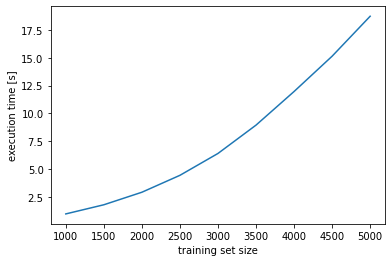

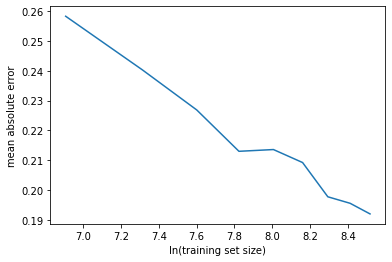

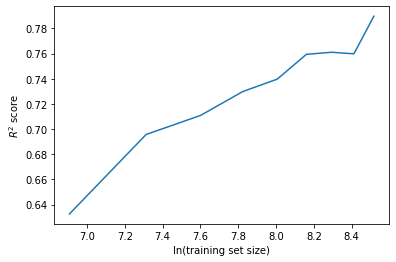

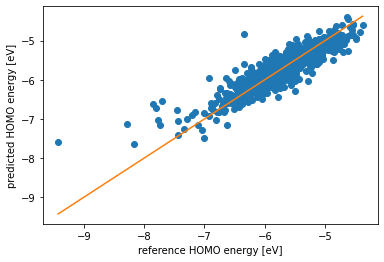

## **Optional Exercise:** Support-Vector Machine
SVM, as discussed in the lecture, can be used for the classification and regression. In this example we will focus on the former.

We will work with a data set of various metal alloys that was assembled primarily by Vanessa Nilsen under the guidance of Prof. Dane Morgan at UW Madison. It can be found here:
https://figshare.com/articles/dataset/MAST-ML_Education_Datasets/7017254.

For each metal alloy the reduced glass transition temperature $T_{rg}$ has been measured. At the glass transition temperature the alloy acquires a glassy structure. For chemical/physical background, see for instance: https://www.sciencedirect.com/science/article/abs/pii/S0022309300000648.

Additionally, the data set is complemented with Magpie descriptors (https://www.nature.com/articles/npjcompumats201628), information solely derived from single atom properties averaged over the material composition. These descriptors are attribute-based, as discussed in the lecture. An example of such a descriptor is the average number of valence electrons in d-orbitals relative to the total number of valence electrons.

The exercise will consist of classifying these metal alloys by their majority atomic element with reduced glass transition temperature and one or more Magpie descriptors as input.

The exercise is based with his kind permission on a notebook by Prof. Tomi Ohtsuki of Sophia University, Japan.

First we import all the necessary libraries.

In [ ]:
import numpy as np
#from sklearn import preprocessing, cross_validation, neighbors, svm
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt

In the following we will load our data.

In [ ]:
#@title Data

data=np.array([['Material compositions','main_element','Trg','Density_composition_average','IsBoron_composition_average','IsDBlock_composition_average','IsTransitionMetal_composition_average','NdValence_composition_average','NValance_composition_average','HeatVaporization_max_value','BoilingT_difference','HeatVaporization_difference','MeltingT_difference','NdValence_difference','NsUnfilled_difference','valence_difference','Site1_Density','Site1_HeatCapacityMass','Site1_HeatFusion','Site1_IsDBlock','Site1_IsTransitionMetal','Site1_NdValence','Site1_SpecificHeatCapacity'],
 ['Ag10Cu35Zr55','Zr',0.534,0.579069323,-0.585599963,1.029882069,1.029882069,0.589535856,0.217570998,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,1.091651325,-0.887076926,-0.454471416,0.718013956,0.718013956,1.317680438,-0.884993683],
 ['Ag10Cu50Zr40','Cu',0.608,0.748401453,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,1.091651325,-0.887076926,-0.454471416,0.718013956,0.718013956,1.317680438,-0.884993683],
 ['Ag10Cu55Zr35','Cu',0.609,0.804845496,-0.585599963,1.029882069,1.029882069,1.371821586,0.799434834,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,1.091651325,-0.887076926,-0.454471416,0.718013956,0.718013956,1.317680438,-0.884993683],
 ['Ag20Cu40Zr40','Cu',0.577,0.821973182,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,1.091651325,-0.887076926,-0.454471416,0.718013956,0.718013956,1.317680438,-0.884993683],
 ['Ag35Ca65','Ca',0.515,-0.860991846,-0.585599963,-0.9989612,-0.9989612,-0.437214166,-0.613663053,-1.684369924,-1.368929027,-1.228444564,-1.429883953,1.005911258,0.85784908,-1.745034863,1.091651325,-0.887076926,-0.454471416,0.718013956,0.718013956,1.317680438,-0.884993683],
 ['Al13.3Co26.7Zr60','Zr',0.573,0.058889078,0.464229426,0.614749523,0.614749523,-0.647942385,-0.592050968,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al15.4Co26Zr58.6','Zr',0.565,0.013549211,0.629991961,0.549202279,0.549202279,-0.685589886,-0.615325521,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al15Ca70Mg15','Ca',0.545,-2.233221755,0.598418145,-2.091415267,-2.091415267,-2.148464202,-1.860514129,-1.418640068,-0.453058277,-0.750370303,-1.318556057,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al16.9Co25.6Zr57.5','Zr',0.572,-0.0177169,0.748393772,0.502382819,0.502382819,-0.710036315,-0.629872117,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al18Sr82','Sr',0.527,-1.815268726,0.835221766,-2.091415267,-2.091415267,-2.148464202,-1.848045619,-1.418640068,-0.809162484,-0.816493007,-1.435135997,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al19.4Co24.8Zr55.8','Zr',0.577,-0.071319762,0.945730123,0.424350386,0.424350386,-0.754039887,-0.656887224,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al20Ca65Mg15','Ca',0.597,-2.206276695,0.993090847,-2.091415267,-2.091415267,-2.148464202,-1.839733278,-1.418640068,-0.453058277,-0.750370303,-1.318556057,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al21.2Co21.2Zr57.6','Zr',0.575,-0.143767766,1.087812296,0.368167033,0.368167033,-0.859648461,-0.739179395,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al22.3Co22.3Zr55.4','Zr',0.578,-0.151097759,1.17464029,0.333832763,0.333832763,-0.843513817,-0.720892245,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al22Co24Zr54','Zr',0.584,-0.126708497,1.150959928,0.343196655,0.343196655,-0.799021317,-0.684317947,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al23.5Co23.5Zr53','Zr',0.593,-0.159094116,1.269361739,0.296377195,0.296377195,-0.825912389,-0.700942628,0.56391502,0.109147336,0.220140354,0.23007105,-0.324238123,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al30Ca60Mg10','Ca',0.582,-2.156791506,1.782436252,-2.091415267,-2.091415267,-2.148464202,-1.798171576,-1.418640068,-0.453058277,-0.750370303,-1.318556057,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al30Sr70','Sr',0.556,-1.811332404,1.782436252,-2.091415267,-2.091415267,-2.148464202,-1.798171576,-1.418640068,-0.809162484,-0.816493007,-1.435135997,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al32Ca58Mg10','Ca',0.588,-2.146013482,1.940305333,-2.091415267,-2.091415267,-2.148464202,-1.789859235,-1.418640068,-0.453058277,-0.750370303,-1.318556057,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al35Ca65','Ca',0.688,-2.138656309,2.177108955,-2.091415267,-2.091415267,-2.148464202,-1.777390724,-1.418640068,-0.933555049,-0.942837142,-1.334729264,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al35La50Ni15','La',0.548,-0.544586548,2.177108955,-1.623220667,-1.623220667,-1.317285613,-1.070841781,-0.69911215,-1.043313195,-1.137365872,-0.387816537,0.20782163,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al35Sr65','Sr',0.493,-1.80969227,2.177108955,-2.091415267,-2.091415267,-2.148464202,-1.777390724,-1.418640068,-0.809162484,-0.816493007,-1.435135997,-1.654387503,-1.16570621,-0.740265774,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al40La45Ni15','La',0.492,-0.625328007,2.571781658,-1.623220667,-1.623220667,-1.341732042,-1.070841781,-0.69911215,-1.043313195,-1.137365872,-0.387816537,0.20782163,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al85Co5Y10','Al',0.48,-1.56006386,6.123835981,-1.623220667,-1.623220667,-1.92844634,-1.38255455,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-0.058208246,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al85Ni5Y10','Al',0.43,-1.559876416,6.123835981,-1.623220667,-1.623220667,-1.903999911,-1.361773699,-0.740589028,-1.188437854,-1.181945372,-0.27814149,0.20782163,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al86.5Co4.5Y9','Al',0.441,-1.582894527,6.242237792,-1.670040127,-1.670040127,-1.950448126,-1.395023061,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-0.058208246,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al86.5Ni4.5Y9','Al',0.413,-1.582725827,6.242237792,-1.670040127,-1.670040127,-1.92844634,-1.376320295,-0.740589028,-1.188437854,-1.181945372,-0.27814149,0.20782163,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al88Co4Y8','Al',0.43,-1.605725193,6.360639602,-1.716859587,-1.716859587,-1.972449913,-1.407491572,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-0.058208246,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al88Ni4Y8','Al',0.39,-1.605575238,6.360639602,-1.716859587,-1.716859587,-1.952892769,-1.390866891,-0.740589028,-1.188437854,-1.181945372,-0.27814149,0.20782163,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al89.5Co3.5Y7','Al',0.39,-1.62855586,6.479041413,-1.763679047,-1.763679047,-1.994451699,-1.419960082,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-0.058208246,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Al89.5Ni3.5Y7','Al',0.37,-1.628424649,6.479041413,-1.763679047,-1.763679047,-1.977339198,-1.405413487,-0.740589028,-1.188437854,-1.181945372,-0.27814149,0.20782163,-1.16570621,-1.745034863,-1.139306181,1.562289099,-0.584429046,-1.392730589,-1.392730589,-1.10635433,1.575043526],
 ['Au35Ca65','Ca',0.508,0.583966294,-0.585599963,-0.9989612,-0.9989612,-0.437214166,1.422860372,-1.196173176,-0.52257177,-0.703728912,-1.27170473,1.005911258,0.85784908,-0.740265774,3.614723934,-1.279271486,-0.179137453,0.718013956,0.718013956,1.317680438,-1.280819219],
 ['Au49Ag5.5Pd2.3Cu26.9Si16.3','Au',0.623,3.080367076,-0.585599963,0.521110603,0.521110603,1.943868027,4.185051124,-0.740589028,-1.218926228,-0.89633795,-0.698938384,1.005911258,0.85784908,0.264503316,3.614723934,-1.279271486,-0.179137453,0.718013956,0.718013956,1.317680438,-1.280819219],
 ['Au55Cu25Si20','Au',0.532,3.18404745,-0.585599963,0.405622601,0.405622601,1.762964452,4.436083807,-0.967488059,-2.109186744,-1.494783972,-1.075000217,1.005911258,0.85784908,0.264503316,3.614723934,-1.279271486,-0.179137453,0.718013956,0.718013956,1.317680438,-1.280819219],
 ['Au77.8Si8.4Ge13.8','Au',0.466,4.418690726,-0.585599963,0.33695406,0.33695406,2.330121606,6.272279826,-0.967488059,-2.098210929,-1.664925511,-0.880473757,-1.654387503,0.85784908,-0.740265774,3.614723934,-1.279271486,-0.179137453,0.718013956,0.718013956,1.317680438,-1.280819219],
 ['Au77Si9.4Ge13.6','Au',0.469,4.35226717,-0.585599963,0.311983681,0.311983681,2.281228748,6.194143825,-0.967488059,-2.098210929,-1.664925511,-0.880473757,-1.654387503,0.85784908,-0.740265774,3.614723934,-1.279271486,-0.179137453,0.718013956,0.718013956,1.317680438,-1.280819219],
 ['Be30Zr70','Zr',0.44,-0.658036967,-0.585599963,0.093492868,0.093492868,-1.463964188,-1.340992848,0.56391502,0.168904549,0.176058551,-0.737741725,-1.654387503,-1.16570621,0.264503316,-1.383308208,4.995841474,-1.20448113,-1.392730589,-1.392730589,-1.10635433,4.996899795],
 ['Be32.5Zr67.5','Zr',0.496,-0.712665148,-0.585599963,0.015460435,0.015460435,-1.488410617,-1.361773699,0.56391502,0.168904549,0.176058551,-0.737741725,-1.654387503,-1.16570621,0.264503316,-1.383308208,4.995841474,-1.20448113,-1.392730589,-1.392730589,-1.10635433,4.996899795],
 ['Be40Zr60','Zr',0.464,-0.87654969,-0.585599963,-0.218636866,-0.218636866,-1.561749904,-1.424116253,0.56391502,0.168904549,0.176058551,-0.737741725,-1.654387503,-1.16570621,0.264503316,-1.383308208,4.995841474,-1.20448113,-1.392730589,-1.392730589,-1.10635433,4.996899795],
 ['Be45Zr55','Zr',0.457,-0.985806051,-0.585599963,-0.374701732,-0.374701732,-1.610642762,-1.465677955,0.56391502,0.168904549,0.176058551,-0.737741725,-1.654387503,-1.16570621,0.264503316,-1.383308208,4.995841474,-1.20448113,-1.392730589,-1.392730589,-1.10635433,4.996899795],
 ['Be50Zr50','Be',0.456,-1.095062413,-0.585599963,-0.530766599,-0.530766599,-1.65953562,-1.507239658,0.56391502,0.168904549,0.176058551,-0.737741725,-1.654387503,-1.16570621,0.264503316,-1.383308208,4.995841474,-1.20448113,-1.392730589,-1.392730589,-1.10635433,4.996899795],
 ['Ca40Mg25Cu35','Ca',0.587,-1.096468242,-0.585599963,-0.9989612,-0.9989612,-0.437214166,-0.613663053,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca40Mg30Cu30','Ca',0.569,-1.264746,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.800690714,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca45Mg19Cu36','Ca',0.559,-1.067217622,-0.585599963,-0.967748226,-0.967748226,-0.388321308,-0.576257521,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca45Mg25Cu30','Ca',0.59,-1.269150932,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.800690714,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca45Mg30Cu25','Ca',0.559,-1.43742869,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.987718376,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca47.5Mg22.5Cu30','Ca',0.593,-1.271353398,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.800690714,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca47Mg19Zn7Cu27','Ca',0.581,-1.194679472,-0.585599963,-1.030174173,-1.030174173,-0.486107024,-0.621975393,-1.354473287,0.26768688,-0.593951003,-0.58776496,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg10Zn15Cu25','Ca',0.563,-1.062119148,-0.585599963,-0.842896333,-0.842896333,-0.192749875,-0.364292838,-1.354473287,0.26768688,-0.593951003,-0.58776496,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg15Zn10Cu25','Ca',0.583,-1.188690639,-0.585599963,-0.9989612,-0.9989612,-0.437214166,-0.57210135,-1.354473287,0.26768688,-0.593951003,-0.58776496,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg20Cu30','Ca',0.581,-1.273555863,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.800690714,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg20Zn5Cu25','Ca',0.61,-1.315262131,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.779909863,-1.354473287,0.26768688,-0.593951003,-0.58776496,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg22.5Cu27.5','Ca',0.603,-1.357694743,-0.585599963,-1.2330585,-1.2330585,-0.803910602,-0.894204545,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg25Cu25','Ca',0.611,-1.441833622,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.987718376,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg25Zn15Cu10','Ca',0.53,-1.566952423,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.925375822,-1.354473287,0.26768688,-0.593951003,-0.58776496,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg30Ag20','Ca',0.609,-1.462967921,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.684369924,-0.888432256,-1.035977725,-1.133297911,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca50Mg30Cu20','Ca',0.55,-1.61011138,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca53Mg23Cu24','Ca',0.62,-1.478132133,-0.585599963,-1.342303906,-1.342303906,-0.975035606,-1.025123908,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg10Cu35','Ca',0.516,-1.109683037,-0.585599963,-0.9989612,-0.9989612,-0.437214166,-0.613663053,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg11Zn11Cu23','Ca',0.529,-1.235092376,-0.585599963,-1.030174173,-1.030174173,-0.486107024,-0.605350712,-1.354473287,0.26768688,-0.593951003,-0.58776496,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg15Cu30','Ca',0.562,-1.277960795,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.800690714,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg15Zn30','Ca',0.556,-1.528198397,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.676005607,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg18Zn27','Ca',0.58,-1.604141292,-0.585599963,-1.248664986,-1.248664986,-0.828357031,-0.800690714,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg20Cu25','Ca',0.554,-1.446238554,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.987718376,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg20Zn25','Ca',0.546,-1.654769889,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.883814119,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg25Ag20','Ca',0.617,-1.467372853,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.684369924,-0.888432256,-1.035977725,-1.133297911,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg25Cu20','Ca',0.596,-1.614516312,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca55Mg25Zn20','Ca',0.499,-1.78134138,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.091622632,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca58Mg18Cu24','Ca',0.582,-1.482537064,-0.585599963,-1.342303906,-1.342303906,-0.975035606,-1.025123908,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Al30Ag10','Ca',0.556,-1.746664259,1.782436252,-1.779285533,-1.779285533,-1.65953562,-1.424116253,-1.418640068,-0.933555049,-0.942837142,-1.149471118,-1.654387503,-1.16570621,-0.740265774,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg10Zn30','Ca',0.571,-1.532603329,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.676005607,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg13Cu27','Ca',0.562,-1.383332382,-0.585599963,-1.248664986,-1.248664986,-0.828357031,-0.912907311,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg15Cu25','Ca',0.576,-1.450643485,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.987718376,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg15Zn25','Ca',0.583,-1.65917482,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.883814119,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg17.5Zn22.5','Ca',0.589,-1.722460566,-0.585599963,-1.389123367,-1.389123367,-1.048374893,-0.987718376,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg20Ag20','Ca',0.602,-1.471777784,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.684369924,-0.888432256,-1.035977725,-1.133297911,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg20Cu20','Ca',0.571,-1.618921244,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg20Zn20','Ca',0.573,-1.785746312,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.091622632,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg25Cu15','Ca',0.577,-1.787199002,-0.585599963,-1.623220667,-1.623220667,-1.41507133,-1.361773699,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca60Mg25Zn15','Ca',0.507,-1.912317803,-0.585599963,-1.623220667,-1.623220667,-1.41507133,-1.299431145,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca62.5Mg17.5Zn20','Ca',0.586,-1.787948778,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.091622632,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca63Al32Cu5','Ca',0.616,-1.982140655,1.940305333,-1.9353504,-1.9353504,-1.903999911,-1.602831574,-1.354473287,-0.435984788,-0.873870451,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Cu35','Ca',0.424,-1.1184929,-0.585599963,-0.9989612,-0.9989612,-0.437214166,-0.613663053,-1.354473287,-0.435984788,-0.873870451,-1.240130675,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Ga35','Ca',0.567,-1.613157344,2.177108955,-2.091415267,-2.091415267,-0.437214166,-0.322731135,-1.648449757,-1.317708559,-1.189837437,-0.360691272,-1.654387503,-1.16570621,-0.740265774,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg10Cu25','Ca',0.546,-1.455048417,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.987718376,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg10Zn25','Ca',0.572,-1.663579752,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.883814119,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg15Ag20','Ca',0.584,-1.476182716,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.684369924,-0.888432256,-1.035977725,-1.133297911,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg15Cu20','Ca',0.562,-1.623326175,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg15Zn20','Ca',0.595,-1.790151243,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.091622632,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg20Cu15','Ca',0.568,-1.791603934,-0.585599963,-1.623220667,-1.623220667,-1.41507133,-1.361773699,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg20Zn15','Ca',0.569,-1.916722735,-0.585599963,-1.623220667,-1.623220667,-1.41507133,-1.299431145,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg25Cu10','Ca',0.586,-1.959881692,-0.585599963,-1.779285533,-1.779285533,-1.65953562,-1.54880136,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg25Zn10','Ca',0.51,-2.043294226,-0.585599963,-1.779285533,-1.779285533,-1.65953562,-1.507239658,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg35','Ca',0.416,-2.296437209,-0.585599963,-2.091415267,-2.091415267,-2.148464202,-1.922856683,-2.319158,-1.715276954,-1.718250272,-1.318556057,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Mg5Cu30','Ca',0.532,-1.286770658,-0.585599963,-1.155026066,-1.155026066,-0.681678457,-0.800690714,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca65Zn35','Ca',0.566,-1.410436769,-0.585599963,-0.9989612,-0.9989612,-0.437214166,-0.468197094,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca66.4Al33.6','Ca',0.605,-2.146200926,2.066600598,-2.091415267,-2.091415267,-2.148464202,-1.783209363,-1.418640068,-0.933555049,-0.942837142,-1.334729264,-1.654387503,-1.16570621,-0.740265774,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca70Mg10Ag20','Ca',0.561,-1.480587648,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.684369924,-0.888432256,-1.035977725,-1.133297911,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca70Mg10Cu20','Ca',0.54,-1.627731107,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.174746037,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca70Mg10Zn20','Ca',0.559,-1.794556175,-0.585599963,-1.4671558,-1.4671558,-1.170607039,-1.091622632,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca70Mg15Zn15','Ca',0.539,-1.921127666,-0.585599963,-1.623220667,-1.623220667,-1.41507133,-1.299431145,-2.319158,-1.492102057,-1.630797664,-0.962776384,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ca70Mg20Cu10','Ca',0.507,-1.964286624,-0.585599963,-1.779285533,-1.779285533,-1.65953562,-1.54880136,-1.354473287,0.044511983,-0.681403612,-0.943544633,-1.654387503,-1.16570621,-1.745034863,-1.468651641,0.637301929,-1.062408805,-1.392730589,-1.392730589,-1.10635433,0.639119596],
 ['Ce55Al25Cu20','Ce',0.59,-0.177313663,1.38776355,-1.4671558,-1.4671558,-0.901696319,-0.613663053,-1.26649203,-1.17014483,-1.747187843,-0.95971784,-1.654387503,-1.16570621,0.264503316,0.003092983,-1.04617472,-1.740831689,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['Ce60Al20Co20','Ce',0.531,-0.085723888,0.993090847,-1.4671558,-1.4671558,-1.170607039,-0.759129012,-0.87289167,-1.17014483,-1.324144736,-0.326027778,-1.654387503,-1.16570621,-0.740265774,0.003092983,-1.04617472,-1.740831689,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['Ce60Al20Cu20','Ce',0.564,-0.08384945,0.993090847,-1.4671558,-1.4671558,-0.87724989,-0.592882202,-1.26649203,-1.17014483,-1.747187843,-0.95971784,-1.654387503,-1.16570621,0.264503316,0.003092983,-1.04617472,-1.740831689,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['Ce65Al15Cu20','Ce',0.47,0.009614764,0.598418145,-1.4671558,-1.4671558,-0.852803461,-0.57210135,-1.26649203,-1.17014483,-1.747187843,-0.95971784,-1.654387503,-1.16570621,0.264503316,0.003092983,-1.04617472,-1.740831689,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['Ce68Al10Cu20Fe2','Ce',0.497,0.114185028,0.203745442,-1.404729853,-1.404729853,-0.779464173,-0.518071137,-1.030331814,-1.17014483,-1.493361979,-0.259604862,-0.590267999,0.85784908,2.274041495,0.003092983,-1.04617472,-1.740831689,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['Ce70Al15Cu15','Ce',0.47,-0.042658653,0.598418145,-1.623220667,-1.623220667,-1.072821322,-0.717567309,-1.26649203,-1.17014483,-1.747187843,-0.95971784,-1.654387503,-1.16570621,0.264503316,0.003092983,-1.04617472,-1.740831689,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['Co43.2Fe28.8B19.2Si4.8Nb4','Co',0.58,0.24514833,0.929943215,0.280770708,0.280770708,0.253152991,0.221727168,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.636295428,-0.198886472,0.624837718,0.718013956,0.718013956,0.590470008,-0.196923125],
 ['Co43Fe20Ta5.5B31.5','Co',0.596,0.269974336,1.900838063,0.046673408,0.046673408,-0.009401657,0.346412276,1.533031872,0.971358548,0.844395561,0.735920171,0.20782163,-1.16570621,1.269272405,0.636295428,-0.198886472,0.624837718,0.718013956,0.718013956,0.590470008,-0.196923125],
 ['Co48Cr15Mo14C15B6Er2','Co',0.608,0.437581983,-0.11199272,0.311983681,0.311983681,0.203282276,0.205102487,1.387498966,0.204271062,1.09054266,1.559255381,0.20782163,0.85784908,1.269272405,0.636295428,-0.198886472,0.624837718,0.718013956,0.718013956,0.590470008,-0.196923125],
 ['Co50.4Fe21.6B19.2Si4.8Nb4','Co',0.573,0.279765468,0.929943215,0.280770708,0.280770708,0.288355849,0.251651594,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.636295428,-0.198886472,0.624837718,0.718013956,0.718013956,0.590470008,-0.196923125],
 ['Co50Cr15Mo14C15B6','Co',0.578,0.436026199,-0.11199272,0.374409628,0.374409628,0.271732277,0.163540785,1.387498966,0.204271062,0.759075943,1.559255381,0.20782163,0.85784908,1.269272405,0.636295428,-0.198886472,0.624837718,0.718013956,0.718013956,0.590470008,-0.196923125],
 ['Co57.6Fe14.4B19.2Si4.8Nb4','Co',0.563,0.314382607,0.929943215,0.280770708,0.280770708,0.323558707,0.28157602,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.636295428,-0.198886472,0.624837718,0.718013956,0.718013956,0.590470008,-0.196923125],
 ['Co64.8Fe7.2B19.2Si4.8Nb4','Co',0.551,0.348999746,0.929943215,0.280770708,0.280770708,0.358761565,0.311500446,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.636295428,-0.198886472,0.624837718,0.718013956,0.718013956,0.590470008,-0.196923125],
 ['Cu25Zr75','Zr',0.419,0.279721419,-0.585599963,1.029882069,1.029882069,-0.192749875,-0.364292838,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu28Zr72','Zr',0.473,0.313587845,-0.585599963,1.029882069,1.029882069,-0.075407016,-0.277013262,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu33.5Zr66.5','Zr',0.496,0.375676293,-0.585599963,1.029882069,1.029882069,0.13972156,-0.117000707,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu34Zr50Ag8Al8','Zr',0.592,0.387618812,0.045876361,0.780178282,0.780178282,0.393964423,0.097042061,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu35Ag25Zr30Ti10','Cu',0.595,0.764849655,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu38Zr46Ag8Al8','Zr',0.604,0.432774047,0.045876361,0.780178282,0.780178282,0.550421569,0.213414828,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu40Ag20Zr30Ti10','Cu',0.602,0.72806379,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu40Zr40Ag10Al10','Cu',0.558,0.456926193,0.203745442,0.717752335,0.717752335,0.687321572,0.321475254,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu40Zr44Ag8Al8','Zr',0.589,0.455351664,0.045876361,0.780178282,0.780178282,0.628650142,0.271601211,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu40Zr60','Zr',0.518,0.44905355,-0.585599963,1.029882069,1.029882069,0.393964423,0.072105039,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu42Zr42Ag16','Cu',0.556,0.769966873,-0.585599963,1.029882069,1.029882069,1.098021581,0.595782491,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu42Zr42Ag8Al8','Cu',0.581,0.477929282,0.045876361,0.780178282,0.780178282,0.706878715,0.329787595,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu43Zr40Ag7Ti10','Cu',0.599,0.519532455,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu43Zr43Ag7In7','Cu',0.62,0.63965119,-0.033058179,0.811391255,0.811391255,1.058907294,0.624875683,0.56391502,0.65427946,0.678484453,1.008176889,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu43Zr43Ag7Ti7','Cu',0.599,0.547705272,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu43Zr43Al7Ag7','Cu',0.631,0.488430826,-0.033058179,0.811391255,0.811391255,0.716657287,0.333943765,0.56391502,0.544521314,0.505747776,0.23007105,-1.654387503,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu43Zr43Al7Be7','Cu',0.631,0.204950049,-0.033058179,0.592900442,0.592900442,0.37440728,0.072105039,0.56391502,0.168904549,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu44Zr44Ag12','Cu',0.592,0.717960564,-0.585599963,1.029882069,1.029882069,1.019793007,0.537596108,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu44Zr44Ag6Al6','Cu',0.61,0.49893237,-0.11199272,0.842604228,0.842604228,0.726435858,0.338099936,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Ag15Zr30Ti10','Cu',0.613,0.691277925,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Ni5Ag10Zr30Ti10','Cu',0.612,0.654210895,-0.585599963,1.029882069,1.029882069,1.127357295,0.633188024,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr15Ag10Hf30','Cu',0.558,1.647780701,-0.585599963,1.029882069,1.029882069,0.980678721,2.254094423,1.030744892,0.781111095,1.007498231,0.34830384,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr25Ag10Hf20','Cu',0.573,1.329172937,-0.585599963,1.029882069,1.029882069,0.980678721,1.672230587,1.030744892,0.781111095,1.007498231,0.34830384,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr35Ag10Hf10','Cu',0.589,1.010565173,-0.585599963,1.029882069,1.029882069,0.980678721,1.090366752,1.030744892,0.781111095,1.007498231,0.34830384,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr45Ag10','Cu',0.589,0.691957409,-0.585599963,1.029882069,1.029882069,0.980678721,0.508502916,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr45Ag3Al7','Cu',0.602,0.436424517,-0.033058179,0.811391255,0.811391255,0.638428714,0.275757382,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr45Ag5Al5','Cu',0.608,0.509433915,-0.19092726,0.873817202,0.873817202,0.73621443,0.342256106,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr45Ag7Al3','Cu',0.598,0.582443313,-0.348796342,0.936243149,0.936243149,0.834000146,0.40875483,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr45Al10','Cu',0.609,0.32691042,0.203745442,0.717752335,0.717752335,0.491750139,0.176009296,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr48Al7','Zr',0.597,0.380486572,-0.033058179,0.811391255,0.811391255,0.521085854,0.188477806,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu45Zr55','Zr',0.549,0.505497593,-0.585599963,1.029882069,1.029882069,0.589535856,0.217570998,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu46.4Ag11.6Zr35Ti7','Cu',0.616,0.671858738,-0.585599963,1.029882069,1.029882069,1.098021581,0.595782491,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu46Zr37Al7Y10','Cu',0.595,0.296225854,-0.033058179,0.811391255,0.811391255,0.511307282,0.176009296,0.56391502,0.109147336,0.220140354,0.23007105,0.739881382,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu46Zr42Al7Y5','Cu',0.604,0.344000617,-0.033058179,0.811391255,0.811391255,0.535753712,0.196790147,0.56391502,0.109147336,0.220140354,0.23007105,0.739881382,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu46Zr46Ag8','Cu',0.58,0.665954255,-0.585599963,1.029882069,1.029882069,0.941564434,0.479409724,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu46Zr46Al8','Cu',0.607,0.373916663,0.045876361,0.780178282,0.780178282,0.550421569,0.213414828,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu46Zr47Al7','Zr',0.606,0.391775381,-0.033058179,0.811391255,0.811391255,0.560200141,0.217570998,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu46Zr54','Zr',0.58,0.516786402,-0.585599963,1.029882069,1.029882069,0.628650142,0.24666419,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ni13Zr30Ti10','Cu',0.581,0.5801893,-0.585599963,1.029882069,1.029882069,1.049128722,0.599938662,0.56391502,-0.371349436,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Nb11Ni8Si','Cu',0.561,0.394577667,-0.585599963,0.998669095,0.998669095,1.000235864,0.520971427,1.222782177,0.053048728,0.859326494,0.53546199,1.005911258,0.85784908,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr11Ni2Sn6Si','Cu',0.583,0.243511944,-0.585599963,0.811391255,0.811391255,0.951343006,0.57500164,0.56391502,0.007925935,0.223197641,0.891813209,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr11Ni4Sn4Si','Cu',0.607,0.258488712,-0.585599963,0.873817202,0.873817202,0.931785863,0.541752278,0.56391502,0.007925935,0.223197641,0.891813209,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr11Ni8Si','Cu',0.622,0.288442246,-0.585599963,0.998669095,0.998669095,0.892671576,0.475253554,0.56391502,-0.355495481,0.151173663,-0.425353208,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr11SiNi6Sn2','Cu',0.632,0.273465479,-0.585599963,0.936243149,0.936243149,0.912228719,0.508502916,0.56391502,0.007925935,0.223197641,0.891813209,-1.122327751,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr11Sn8Si','Cu',0.524,0.228535177,-0.585599963,0.748965308,0.748965308,0.970900149,0.608251002,0.56391502,0.007925935,0.223197641,0.891813209,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr3Nb8Ni8Si','Cu',0.577,0.365631643,-0.585599963,0.998669095,0.998669095,0.970900149,0.508502916,1.222782177,0.053048728,0.859326494,0.53546199,1.005911258,0.85784908,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr5Nb6Ni8Si','Cu',0.6,0.346334294,-0.585599963,0.998669095,0.998669095,0.951343006,0.500190575,1.222782177,0.053048728,0.859326494,0.53546199,1.005911258,0.85784908,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr7Nb4Ni8Si','Cu',0.608,0.327036945,-0.585599963,0.998669095,0.998669095,0.931785863,0.491878235,1.222782177,0.053048728,0.859326494,0.53546199,1.005911258,0.85784908,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Ti33Zr9Nb2Ni8Si','Cu',0.628,0.307739596,-0.585599963,0.998669095,0.998669095,0.912228719,0.483565894,1.222782177,0.053048728,0.859326494,0.53546199,1.005911258,0.85784908,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Zr43Al7Ag3','Cu',0.619,0.459002134,-0.033058179,0.811391255,0.811391255,0.716657287,0.333943765,0.56391502,0.544521314,0.505747776,0.23007105,-1.654387503,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Zr43Al7Be3','Cu',0.628,0.337510373,-0.033058179,0.717752335,0.717752335,0.569978712,0.221727168,0.56391502,0.168904549,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu47Zr47Al6','Cu',0.602,0.420922907,-0.11199272,0.842604228,0.842604228,0.609092999,0.25082036,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu48Zr48Ag4','Cu',0.568,0.613947946,-0.585599963,1.029882069,1.029882069,0.863335861,0.421223341,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu48Zr48Al4','Cu',0.58,0.46792915,-0.269861801,0.905030175,0.905030175,0.667764429,0.288225892,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu48Zr52','Zr',0.571,0.539364019,-0.585599963,1.029882069,1.029882069,0.706878715,0.304850573,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu49.4Zr41.99Ti7.41Sn0.6Si0.6','Cu',0.598,0.476072463,-0.585599963,0.992426501,0.992426501,0.779240145,0.370518064,0.56391502,0.007925935,0.223197641,0.891813209,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu49.5Zr42.075Ti7.425Si','Cu',0.599,0.466976935,-0.585599963,0.998669095,0.998669095,0.755771573,0.348490361,0.56391502,-0.355495481,0.151173663,-0.425353208,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu49.5Zr42.075Ti7.425Sn','Cu',0.599,0.4903137,-0.585599963,0.998669095,0.998669095,0.804664431,0.390052064,0.56391502,0.007925935,0.223197641,0.891813209,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu49Hf42Al9','Cu',0.623,1.72807698,0.124810902,0.748965308,0.748965308,0.657985857,2.740366343,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu49Zr36Ag10Ti5','Cu',0.612,0.690157948,-0.585599963,1.029882069,1.029882069,1.137135867,0.624875683,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu50Ag10Zr30Ti10','Cu',0.614,0.654492061,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu50Hf42.5Al7.5','Cu',0.63,1.782084253,0.006409091,0.795784768,0.795784768,0.711768001,2.804786982,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu50Hf45Al5','Cu',0.62,1.906382987,-0.19092726,0.873817202,0.873817202,0.73621443,2.960643367,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu50Zr42.5Ti7.5','Cu',0.588,0.491509592,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu50Zr43Al7','Cu',0.613,0.436930615,-0.033058179,0.811391255,0.811391255,0.716657287,0.333943765,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu50Zr45Al5','Cu',0.61,0.47264805,-0.19092726,0.873817202,0.873817202,0.73621443,0.342256106,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu50Zr50','Cu',0.555,0.561941636,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu51.5Zr40.5Al8','Cu',0.621,0.436005111,0.045876361,0.780178282,0.780178282,0.765550145,0.373427383,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu52.4Zr41.1Al6.5','Cu',0.619,0.472953115,-0.07252545,0.826997742,0.826997742,0.81542086,0.405845511,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu52.5Hf40Al7.5','Cu',0.623,1.730654334,0.006409091,0.795784768,0.795784768,0.809553717,2.732054002,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu52.5Zr40Ga7.5','Cu',0.611,0.5688302,0.006409091,0.795784768,0.795784768,1.176250154,0.716311429,0.56391502,0.493300846,0.467140649,1.204109043,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu52.5Zr42.5Al5','Cu',0.61,0.500870072,-0.19092726,0.873817202,0.873817202,0.834000146,0.414989085,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu52.5Zr42.5Ga5','Cu',0.618,0.575941352,-0.19092726,0.873817202,0.873817202,1.078464437,0.622797598,0.56391502,0.493300846,0.467140649,1.204109043,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu53.2Zr41.8Al5','Cu',0.613,0.508772238,-0.19092726,0.873817202,0.873817202,0.861380147,0.435354319,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu54Ag6Zr33Ti7','Cu',0.625,0.653236186,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu54Ni6Zr22Ti18','Cu',0.553,0.505455418,-0.585599963,1.029882069,1.029882069,1.117578724,0.629031853,0.56391502,-0.371349436,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu54Zr27Ti9Be10','Cu',0.637,0.304065695,-0.585599963,0.717752335,0.717752335,0.843778718,0.396286319,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu54Zr36Ag10','Cu',0.627,0.793556688,-0.585599963,1.029882069,1.029882069,1.3327073,0.770341642,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55.2Hf23Ti13.8Nb8','Cu',0.622,1.301035734,-0.585599963,1.029882069,1.029882069,1.066730151,1.885857739,1.222782177,0.020121284,0.859326494,0.53546199,0.473851506,-1.16570621,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55Ag5Zr30Ti10','Cu',0.613,0.617706196,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55Hf45','Cu',0.595,2.052120617,-0.585599963,1.029882069,1.029882069,0.980678721,3.126890177,1.030744892,-0.151833144,0.652924118,0.158550562,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55Ni5Zr30Ti10','Cu',0.596,0.580639165,-0.585599963,1.029882069,1.029882069,1.127357295,0.633188024,0.56391502,-0.371349436,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55Zr40Al5','Cu',0.62,0.529092093,-0.19092726,0.873817202,0.873817202,0.931785863,0.487722065,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55Zr40Ga5','Cu',0.617,0.604163374,-0.19092726,0.873817202,0.873817202,1.176250154,0.695530577,0.56391502,0.493300846,0.467140649,1.204109043,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55Zr42.5Ga2.5','Cu',0.591,0.611274527,-0.388263612,0.951849635,0.951849635,1.078464437,0.602016747,0.56391502,0.493300846,0.467140649,1.204109043,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu55Zr45','Cu',0.59,0.61838568,-0.585599963,1.029882069,1.029882069,0.980678721,0.508502916,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu56.4Hf23.5Ti14.1Nb6','Cu',0.626,1.308398061,-0.585599963,1.029882069,1.029882069,1.094110152,1.94155042,1.222782177,0.020121284,0.859326494,0.53546199,0.473851506,-1.16570621,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu56Zr44','Cu',0.626,0.629674489,-0.585599963,1.029882069,1.029882069,1.019793007,0.537596108,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu57.5Zr37.5Ga5','Cu',0.6,0.632385396,-0.19092726,0.873817202,0.873817202,1.27403587,0.768263557,0.56391502,0.493300846,0.467140649,1.204109043,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu57.6Hf24Ti14.4Nb4','Cu',0.629,1.315760389,-0.585599963,1.029882069,1.029882069,1.121490152,1.997243101,1.222782177,0.020121284,0.859326494,0.53546199,0.473851506,-1.16570621,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu57.6Zr28.8Ti9.6Sn4','Cu',0.656,0.572560333,-0.585599963,0.905030175,0.905030175,1.238833012,0.750392025,0.56391502,0.007925935,0.223197641,0.891813209,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu57Zr36Ag7','Cu',0.616,0.771485169,-0.585599963,1.029882069,1.029882069,1.3327073,0.770341642,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu58.1Zr35.9Al6','Cu',0.648,0.546228683,-0.11199272,0.842604228,0.842604228,1.043261579,0.573754789,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu58.2Zr29.1Ti9.7Sn3','Cu',0.651,0.574650333,-0.585599963,0.936243149,0.936243149,1.223187297,0.726286237,0.56391502,0.007925935,0.223197641,0.891813209,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu58.7Zr36.3Al5','Cu',0.634,0.570860686,-0.19092726,0.873817202,0.873817202,1.076508723,0.595366874,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu58.8Hf24.5Ti14.7Nb2','Cu',0.63,1.323122717,-0.585599963,1.029882069,1.029882069,1.148870153,2.052935783,1.222782177,0.020121284,0.859326494,0.53546199,0.473851506,-1.16570621,1.269272405,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu58.8Zr29.4Ti9.8Sn2','Cu',0.635,0.576740332,-0.585599963,0.967456122,0.967456122,1.207541583,0.70218045,0.56391502,0.007925935,0.223197641,0.891813209,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu58.8Zr29.4Ti9.8Y2','Cu',0.63,0.550142043,-0.585599963,1.029882069,1.029882069,1.119534438,0.610744704,0.56391502,-0.388422925,0.151173663,-0.425353208,0.739881382,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu59.4Zr29.7Ti9.9Sn','Cu',0.632,0.578830332,-0.585599963,0.998669095,0.998669095,1.191895868,0.678074662,0.56391502,0.007925935,0.223197641,0.891813209,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu59.6Zr36.9Al3.5','Cu',0.627,0.607808689,-0.309329071,0.920636662,0.920636662,1.126379438,0.627785002,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60.3Zr37.2Al2.5','Cu',0.619,0.633569573,-0.388263612,0.951849635,0.951849635,1.16353801,0.652306407,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60Hf17.5Ti22.5','Cu',0.596,1.021097177,-0.585599963,1.029882069,1.029882069,1.176250154,1.672230587,1.030744892,-0.151833144,0.652924118,0.158550562,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60Hf20Ti20','Cu',0.611,1.124226466,-0.585599963,1.029882069,1.029882069,1.176250154,1.817696546,1.030744892,-0.151833144,0.652924118,0.158550562,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60Hf25Ti15','Cu',0.62,1.330485044,-0.585599963,1.029882069,1.029882069,1.176250154,2.108628464,1.030744892,-0.151833144,0.652924118,0.158550562,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60Hf40','Cu',0.599,1.949260779,-0.585599963,1.029882069,1.029882069,1.176250154,2.981424218,1.030744892,-0.151833144,0.652924118,0.158550562,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60Zr30Ti10','Cu',0.616,0.580920331,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60Zr33Ti7','Cu',0.621,0.609093149,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu60Zr40','Cu',0.618,0.674829723,-0.585599963,1.029882069,1.029882069,1.176250154,0.653968875,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu62Zr38','Cu',0.629,0.697407341,-0.585599963,1.029882069,1.029882069,1.254478727,0.712155258,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu64Zr36','Cu',0.64,0.719984958,-0.585599963,1.029882069,1.029882069,1.3327073,0.770341642,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu65Hf35','Cu',0.62,1.84640094,-0.585599963,1.029882069,1.029882069,1.371821586,2.835958259,1.030744892,-0.151833144,0.652924118,0.158550562,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu65Zr35','Cu',0.626,0.731273767,-0.585599963,1.029882069,1.029882069,1.371821586,0.799434834,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu66Zr34','Cu',0.603,0.742562576,-0.585599963,1.029882069,1.029882069,1.410935873,0.828528026,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Cu72Zr28','Cu',0.574,0.810295428,-0.585599963,1.029882069,1.029882069,1.645621592,1.003087176,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,0.642023175,-0.332084625,0.052143075,0.718013956,0.718013956,1.317680438,-0.330098072],
 ['Dy46Al24Co18Fe2Y10','Dy',0.613,0.127371706,1.308829009,-1.155026066,-1.155026066,-1.424849901,0.703842918,-0.740589028,-1.188437854,-0.749659306,-0.259604862,-0.058208246,-1.16570621,1.269272405,0.536346241,-1.116473745,-0.443458057,-1.392730589,-1.392730589,-1.10635433,-1.114350535],
 ['Er50Al24Co20Y6','Er',0.603,0.334112952,1.308829009,-1.27987796,-1.27987796,-1.434628473,1.277394413,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-0.058208246,-1.16570621,-1.745034863,0.683835729,-1.134973488,1.439826247,-1.392730589,-1.392730589,-1.10635433,-1.132847056],
 ['Fe27Co40Zr3Ti3Mo1.5Si1.5B24','Co',0.588,0.131087781,1.308829009,0.233951248,0.233951248,0.107941203,0.101198231,0.56391502,-0.027440579,-0.197214778,0.252423134,0.20782163,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe36Co36B19.2Si4.8Nb4','Fe',0.587,0.210531191,0.929943215,0.280770708,0.280770708,0.217950133,0.191802743,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe39Co9Cr15Mo14C15B6Y2','Fe',0.572,0.207016618,-0.11199272,0.374409628,0.374409628,0.022378701,-0.048423898,1.387498966,0.204271062,0.759075943,1.559255381,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe41.9Co27.9B18.6Si4.7Nb3.9Cr3','Fe',0.564,0.178762262,0.882582491,0.302619789,0.302619789,0.185191918,0.148578572,1.222782177,0.332322232,0.582037735,0.026894165,-0.856297875,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe41Co7Cr15Mo14C15B6Y2','Fe',0.584,0.197400746,-0.11199272,0.374409628,0.374409628,0.012600129,-0.056736239,1.387498966,0.204271062,0.759075943,1.559255381,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe43.2Co28.8B19.2Si4.8Nb4','Fe',0.586,0.175914052,0.929943215,0.280770708,0.280770708,0.182747276,0.161878317,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe43Co5Cr15Mo14C15B6Y2','Fe',0.579,0.187784874,-0.11199272,0.374409628,0.374409628,0.002821557,-0.065048579,1.387498966,0.204271062,0.759075943,1.559255381,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe45Co3Cr15Mo14C15B6Y2','Fe',0.577,0.178169002,-0.11199272,0.374409628,0.374409628,-0.006957014,-0.07336092,1.387498966,0.204271062,0.759075943,1.559255381,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe48Cr15Mo14C15B6Y2','Fe',0.573,0.163745194,-0.11199272,0.374409628,0.374409628,-0.021624872,-0.085829431,1.387498966,0.204271062,0.759075943,1.511369093,-0.324238123,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe48Cr15Mo14Er2C15B6','Fe',0.584,0.206801057,-0.11199272,0.311983681,0.311983681,-0.031403443,0.005606315,1.387498966,0.204271062,1.09054266,1.556165943,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe50.4Co21.6B19.2Si4.8Nb4','Fe',0.586,0.141296913,0.929943215,0.280770708,0.280770708,0.147544418,0.131953891,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe56Co16Y6B22','Fe',0.59,0.059338943,1.150959928,0.343196655,0.343196655,0.071271559,0.055480358,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe56Co20Mo4P9C4B4Si3','Fe',0.603,0.23762152,-0.269861801,0.405622601,0.405622601,0.276621563,0.309006744,1.387498966,3.119569368,3.084746536,3.800179188,0.20782163,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe56Mn5Cr7Mo12Er2C12B6','Fe',0.566,0.281225656,-0.11199272,0.405622601,0.405622601,0.081050131,0.117822912,1.387498966,0.948187384,1.610565733,1.943890404,-0.058208246,0.85784908,2.274041495,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe57.6Co14.4B19.2Si4.8Nb4','Fe',0.58,0.106679774,0.929943215,0.280770708,0.280770708,0.11234156,0.102029465,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe58Co14Y6B22','Fe',0.593,0.049723071,1.150959928,0.343196655,0.343196655,0.061492987,0.047168018,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe58Cr5Mo14Er2C15B6','Fe',0.56,0.241197012,-0.11199272,0.311983681,0.311983681,0.017489415,0.08872972,1.387498966,0.204271062,1.09054266,1.556165943,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe60Co12Y6B22','Fe',0.588,0.0401072,1.150959928,0.343196655,0.343196655,0.051714416,0.038855677,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe61B15Mo7Zr8Co5Y2Cr2','Fe',0.605,0.268760637,0.598418145,0.561687468,0.561687468,0.120164417,0.030543337,0.56391502,0.204271062,-0.126115096,0.127300897,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe61B15Mo7Zr8Co6Y2Al','Fe',0.602,0.256201896,0.677352685,0.530474495,0.530474495,0.10549656,0.030543337,0.56391502,0.389640375,0.220140354,1.416415218,0.20782163,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe61B15Mo7Zr8Co7Y2','Fe',0.607,0.2852557,0.598418145,0.561687468,0.561687468,0.13972156,0.055480358,0.56391502,-0.027440579,-0.197214778,0.127300897,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe62Co10Y6B22','Fe',0.589,0.030491328,1.150959928,0.343196655,0.343196655,0.041935844,0.030543337,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe63C15Mo14Er2B6','Fe',0.555,0.25839499,-0.11199272,0.311983681,0.311983681,0.041935844,0.130291423,1.387498966,-0.027440579,1.09054266,1.556165943,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe64.8Co7.2B19.2Si4.8Nb4','Fe',0.57,0.072062635,0.929943215,0.280770708,0.280770708,0.077138702,0.072105039,1.222782177,0.100610591,0.510938053,0.026894165,-0.856297875,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe64Co8Y6B22','Fe',0.587,0.020875456,1.150959928,0.343196655,0.343196655,0.032157272,0.022230996,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe65.5Cr4Mo4Ga4P12C5B5.5','Fe',0.564,0.019286869,0.164278172,0.202738275,0.202738275,0.164167989,0.240429935,1.387498966,3.119569368,3.084746536,3.822407694,1.005911258,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe66Co6Y6B22','Fe',0.588,0.011259584,1.150959928,0.343196655,0.343196655,0.022378701,0.013918656,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe67Mo5Y6B22','Fe',0.62,0.03878572,1.150959928,0.343196655,0.343196655,-0.031403443,-0.052580068,0.563253507,-0.027440579,-0.197925775,0.079414609,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe67Ni5Y6B22','Fe',0.59,0.006639092,1.150959928,0.343196655,0.343196655,0.041935844,0.030543337,0.016843596,-0.806723414,-0.785209147,-0.657416338,0.473851506,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe68.3C6.9Si2.5B6.7P8.8Cr2.2Mo2.5Al2.1','Fe',0.604,-0.060064693,0.109023993,0.187131788,0.187131788,-0.029936657,0.082911082,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe68Co4Y6B22','Fe',0.634,0.001643712,1.150959928,0.343196655,0.343196655,0.012600129,0.005606315,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe68Mo4Y6B22','Fe',0.615,0.02751097,1.150959928,0.343196655,0.343196655,-0.026514157,-0.044267728,0.563253507,-0.027440579,-0.197925775,0.079414609,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe68Mo5Ni5Cr2P12.5C5B2.5','Fe',0.567,0.160528188,-0.388263612,0.405622601,0.405622601,0.213060848,0.263288871,1.387498966,3.119569368,3.084746536,3.800179188,0.473851506,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe68Ni4Y6B22','Fe',0.593,0.001793667,1.150959928,0.343196655,0.343196655,0.032157272,0.022230996,0.016843596,-0.806723414,-0.785209147,-0.657416338,0.473851506,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe69.12Nb3.84B19.2Si3.84Y4','Fe',0.636,-0.001904226,0.929943215,0.310735162,0.310735162,-0.026123015,-0.022988136,1.222782177,0.100610591,0.510938053,0.026894165,-0.324238123,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe69.84Nb3.88B19.4Si3.88Y3','Fe',0.607,0.008055043,0.945730123,0.303244049,0.303244049,-0.0091083,-0.007527183,1.222782177,0.100610591,0.510938053,0.026894165,-0.324238123,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe69Mo3Y6B22','Fe',0.61,0.016236219,1.150959928,0.343196655,0.343196655,-0.021624872,-0.035955387,0.563253507,-0.027440579,-0.197925775,0.079414609,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe69Ni3Y6B22','Fe',0.582,-0.003051758,1.150959928,0.343196655,0.343196655,0.022378701,0.013918656,0.016843596,-0.806723414,-0.785209147,-0.657416338,0.473851506,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe70.56Nb3.92B19.6Si3.92Y2','Fe',0.604,0.018014312,0.961517031,0.295752935,0.295752935,0.007906415,0.00793377,1.222782177,0.100610591,0.510938053,0.026894165,-0.324238123,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe70Co2Y6B22','Fe',0.632,-0.00797216,1.150959928,0.343196655,0.343196655,0.002821557,-0.002706025,0.016843596,-0.806723414,-0.785209147,-0.719205097,0.20782163,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe70Mo2Y6B22','Fe',0.601,0.004961469,1.150959928,0.343196655,0.343196655,-0.016735586,-0.027643047,0.563253507,-0.027440579,-0.197925775,0.079414609,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe70Ni2Y6B22','Fe',0.583,-0.007897182,1.150959928,0.343196655,0.343196655,0.012600129,0.005606315,0.016843596,-0.806723414,-0.785209147,-0.657416338,0.473851506,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe71.28Nb3.96B19.8Si3.96Y','Fe',0.603,0.027973581,0.977303939,0.288261822,0.288261822,0.024921129,0.023394724,1.222782177,0.100610591,0.510938053,0.026894165,-0.324238123,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe71MoY6B22','Fe',0.595,-0.006313282,1.150959928,0.343196655,0.343196655,-0.0118463,-0.019330706,0.563253507,-0.027440579,-0.197925775,0.079414609,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe71NiY6B22','Fe',0.586,-0.012742607,1.150959928,0.343196655,0.343196655,0.002821557,-0.002706025,0.016843596,-0.806723414,-0.785209147,-0.657416338,0.473851506,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe72B14.4Si9.6Nb4','Fe',0.61,0.034521371,0.55105742,0.280770708,0.280770708,0.041935844,0.062130231,1.222782177,0.100610591,0.510938053,0.026894165,-1.122327751,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe72B19.2Si4.8Nb4','Fe',0.566,0.037445496,0.929943215,0.280770708,0.280770708,0.041935844,0.042180613,1.222782177,0.100610591,0.510938053,0.026894165,-1.122327751,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe72Nb4B20Si4','Fe',0.593,0.03793285,0.993090847,0.280770708,0.280770708,0.041935844,0.038855677,1.222782177,0.100610591,0.510938053,0.026894165,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe72Y6B22','Fe',0.633,-0.017588032,1.150959928,0.343196655,0.343196655,-0.006957014,-0.011018366,0.016843596,-0.806723414,-0.785209147,-0.767091385,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe73.5B14.7Si9.8Nb2','Fe',0.57,0.01519122,0.574737783,0.265164221,0.265164221,0.04682513,0.077508061,1.222782177,0.100610591,0.510938053,0.026894165,-1.122327751,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe73Mo4Ga3P10C4B4Si2','Fe',0.58,0.111392114,-0.033058179,0.311983681,0.311983681,0.237507277,0.292382063,1.387498966,3.119569368,3.084746536,3.822407694,1.005911258,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe74.25B14.85Si9.9Nb','Fe',0.56,0.005526144,0.586577964,0.257360978,0.257360978,0.049269773,0.085196975,1.222782177,0.100610591,0.510938053,0.026894165,-1.122327751,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe74.25B14.85Si9.9Zr','Fe',0.59,-0.004122531,0.586577964,0.257360978,0.257360978,0.039491201,0.081040805,0.56391502,-0.307933618,-0.197214778,-0.594082861,-0.590267999,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe74.5Mo5.5P12.5C5B2.5','Fe',0.57,0.148817631,-0.388263612,0.405622601,0.405622601,0.171501918,0.234195679,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe74Mo4Ga2P10C4B4Si2','Fe',0.58,0.120623725,-0.11199272,0.343196655,0.343196655,0.217950133,0.271601211,1.387498966,3.119569368,3.084746536,3.822407694,1.005911258,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe74Mo5P10C4B4Si3','Fe',0.6,0.124381976,-0.269861801,0.374409628,0.374409628,0.144610846,0.205102487,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe74Nb6Y3B17','Fe',0.597,0.176660078,0.756287226,0.499261522,0.499261522,0.154389418,0.08041738,1.222782177,0.100610591,0.510938053,-0.14611436,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe74Si3.5C12.7Tm0.6P9.1','Fe',0.544,-0.043468142,-0.585599963,0.220656833,0.220656833,0.024551717,0.205152411,1.387498966,2.373213976,3.084746536,3.800179188,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe75.3Si3.5C12.9Tm.6P7.6','Fe',0.535,-0.00615902,-0.585599963,0.261274316,0.261274316,0.062726321,0.220545634,1.387498966,2.373213976,3.084746536,3.800179188,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe75Mo2Ga3P10C4B4Si2','Fe',0.6,0.088842613,-0.033058179,0.311983681,0.311983681,0.247285848,0.309006744,1.387498966,3.119569368,3.084746536,3.822407694,1.005911258,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe75Mo4P10C4B4Si3','Fe',0.613,0.113107225,-0.269861801,0.374409628,0.374409628,0.149500132,0.213414828,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe76Mo2Ga2P10C4B4Si2','Fe',0.59,0.098074225,-0.11199272,0.343196655,0.343196655,0.227728705,0.288225892,1.387498966,3.119569368,3.084746536,3.822407694,1.005911258,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe76Mo3P10C4B4Si3','Fe',0.6,0.101832475,-0.269861801,0.374409628,0.374409628,0.154389418,0.221727168,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe76Mo4P9C4B4Si3','Fe',0.598,0.141462801,-0.269861801,0.405622601,0.405622601,0.178835847,0.225883339,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe76Si9B10P5','Fe',0.62,0.006915571,0.203745442,0.280770708,0.280770708,0.081050131,0.151072274,0.016843596,2.340286533,1.611561128,1.52171871,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe77Mo2P10C4B4Si3','Fe',0.587,0.090557724,-0.269861801,0.374409628,0.374409628,0.159278704,0.230039509,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe78MoP10C4B4Si3','Fe',0.585,0.079282974,-0.269861801,0.374409628,0.374409628,0.164167989,0.238351849,1.387498966,3.119569368,3.084746536,3.800179188,-0.058208246,0.85784908,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe79P10C4B4Si3','Fe',0.586,0.068008224,-0.269861801,0.374409628,0.374409628,0.169057275,0.24666419,1.387498966,2.373213976,3.084746536,3.800179188,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe79Si10B11','Fe',0.576,0.097343193,0.282679983,0.374409628,0.374409628,0.169057275,0.176009296,0.016843596,-0.806723414,-0.785209147,-0.594082861,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe80P13C7','Fe',0.585,0.083439542,-0.585599963,0.405622601,0.405622601,0.19839299,0.292382063,1.387498966,2.373213976,3.084746536,3.800179188,-0.058208246,-1.16570621,0.264503316,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Fe91B9','Fe',0.369,0.407881498,0.124810902,0.748965308,0.748965308,0.521085854,0.383817808,0.016843596,-0.806723414,-0.785209147,-0.785628013,-0.058208246,-1.16570621,1.269272405,0.342462001,-0.095287909,0.098399181,0.718013956,0.718013956,0.348066531,-0.093342611],
 ['Ga18Sr82','Sr',0.561,-1.545012115,0.835221766,-2.091415267,-2.091415267,-1.268392755,-1.099934973,-1.648449757,-1.193315994,-1.063493302,-0.461098005,1.005911258,-1.16570621,-0.740265774,-0.221721091,-0.376484009,-1.713298293,-1.392730589,-1.392730589,1.317680438,-0.381888329],
 ['Gd36Al24Co20Y20','Gd',0.575,-0.163813016,1.308829009,-0.842896333,-0.842896333,-1.190164182,0.038855677,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-0.058208246,-1.16570621,-1.745034863,0.350194459,-0.887076926,-0.813506903,-1.392730589,-1.392730589,-0.863950853,-0.881294379],
 ['Gd60Co25Al15','Gd',0.601,0.400318136,0.598418145,-1.311090933,-1.311090933,-0.999482035,0.861777388,-0.87289167,-1.304293675,-1.324144736,-0.326027778,0.20782163,-1.16570621,-1.745034863,0.350194459,-0.887076926,-0.813506903,-1.392730589,-1.392730589,-0.863950853,-0.881294379],
 ['Gd60Ni15Al25','Gd',0.599,0.110342428,1.38776355,-1.623220667,-1.623220667,-1.268392755,0.674749726,-0.845108115,-1.304293675,-1.294282869,-0.387816537,0.473851506,-1.16570621,-1.745034863,0.350194459,-0.887076926,-0.813506903,-1.392730589,-1.392730589,-0.863950853,-0.881294379],
 ['Hf47Cu29.25Ni9.75Al14','Hf',0.618,1.684650915,0.519483604,0.592900442,0.592900442,0.12260906,2.679062832,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,1.89926367,-1.223772256,3.047776589,0.718013956,0.718013956,-0.621547376,-1.23642757],
 ['Hf48Cu29.25Ni9.75Al13','Hf',0.613,1.734370409,0.440549064,0.624113415,0.624113415,0.132387632,2.741405386,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,1.89926367,-1.223772256,3.047776589,0.718013956,0.718013956,-0.621547376,-1.23642757],
 ['Hf51Cu27.75Ni9.25Al12','Hf',0.578,1.825261955,0.361614523,0.655326388,0.655326388,0.068826916,2.864012408,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,1.89926367,-1.223772256,3.047776589,0.718013956,0.718013956,-0.621547376,-1.23642757],
 ['Ho35Al24Co20Y21','Ho',0.6,-0.033253656,1.308829009,-0.811683359,-0.811683359,-1.361289186,0.446160362,-0.740589028,-1.188437854,-0.899253037,-0.27814149,-0.058208246,-1.16570621,-1.745034863,0.606224756,-1.146073334,-0.353148518,-1.392730589,-1.392730589,-1.10635433,-1.143944968],
 ['La32Ce32Al16Ni5Cu10Co5','La',0.575,-0.091253483,0.677352685,-1.4671558,-1.4671558,-0.979924892,-0.771597523,-0.69911215,-1.043313195,-1.137365872,-0.326027778,-0.856297875,0.85784908,0.264503316,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La32Ce32Al16Ni5Cu12Co3','La',0.573,-0.09106604,0.677352685,-1.4671558,-1.4671558,-0.950589177,-0.754972842,-0.69911215,-1.043313195,-1.137365872,-0.326027778,-0.856297875,0.85784908,0.264503316,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La32Ce32Al16Ni5Cu15','La',0.566,-0.090784874,0.677352685,-1.4671558,-1.4671558,-0.906585605,-0.73003582,-0.69911215,-1.043313195,-1.137365872,-0.387816537,-1.122327751,-1.16570621,0.264503316,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La32Ce32Al16Ni5Cu5Co10','La',0.553,-0.091722093,0.677352685,-1.4671558,-1.4671558,-1.053264179,-0.813159225,-0.69911215,-1.043313195,-1.137365872,-0.326027778,-0.856297875,0.85784908,0.264503316,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La32Ce32Al16Ni5Cu7Co8','La',0.563,-0.091534649,0.677352685,-1.4671558,-1.4671558,-1.023928464,-0.796534544,-0.69911215,-1.043313195,-1.137365872,-0.326027778,-0.856297875,0.85784908,0.264503316,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al15Ag10Cu20','La',0.529,0.047783027,0.598418145,-1.155026066,-1.155026066,-0.412767737,-0.509758797,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al17.5Ag7.5Cu20','La',0.499,-0.04347872,0.795754496,-1.2330585,-1.2330585,-0.534999882,-0.592882202,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al20Ag5Cu20','La',0.521,-0.134740468,0.993090847,-1.311090933,-1.311090933,-0.657232028,-0.676005607,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al25Ag5Cu15','La',0.526,-0.280478097,1.38776355,-1.4671558,-1.4671558,-0.901696319,-0.842252417,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al25Cu20','La',0.509,-0.317263962,1.38776355,-1.4671558,-1.4671558,-0.901696319,-0.842252417,-0.69911215,-1.043313195,-1.137365872,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al25Ni10Cu10','La',0.56,-0.317826294,1.38776355,-1.4671558,-1.4671558,-0.999482035,-0.883814119,-0.69911215,-1.043313195,-1.137365872,-0.387816537,-1.122327751,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al25Ni15Cu5','La',0.526,-0.31810746,1.38776355,-1.4671558,-1.4671558,-1.048374893,-0.904594971,-0.69911215,-1.043313195,-1.137365872,-0.387816537,-1.122327751,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al25Ni20','La',0.522,-0.318388626,1.38776355,-1.4671558,-1.4671558,-1.097267751,-0.925375822,-0.69911215,-1.043313195,-1.137365872,-0.387816537,-1.654387503,-1.16570621,-1.745034863,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al25Ni5Cu10Co5','La',0.566,-0.318013738,1.38776355,-1.4671558,-1.4671558,-1.023928464,-0.904594971,-0.69911215,-1.043313195,-1.137365872,-0.326027778,-0.856297875,0.85784908,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La55Al25Ni5Cu15','La',0.523,-0.317545128,1.38776355,-1.4671558,-1.4671558,-0.950589177,-0.863033268,-0.69911215,-1.043313195,-1.137365872,-0.387816537,-1.122327751,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La60Al15Ag5Cu20','La',0.528,-0.053999009,0.598418145,-1.311090933,-1.311090933,-0.632785599,-0.676005607,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62.5Al12.5Ag5Cu15Co5','La',0.567,-0.014096889,0.401081793,-1.311090933,-1.311090933,-0.693901671,-0.717567309,-0.69911215,-0.607939216,-0.85175845,-0.326027778,-0.856297875,0.85784908,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62.5Al12.5Ag5Cu15Fe5','La',0.547,-0.038136569,0.401081793,-1.311090933,-1.311090933,-0.718348101,-0.738348161,-0.69911215,-0.607939216,-0.85175845,-0.259604862,-0.590267999,0.85784908,2.274041495,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62.5Al12.5Ag5Cu17.5Co2.5','La',0.552,-0.013862584,0.401081793,-1.311090933,-1.311090933,-0.657232028,-0.696786458,-0.69911215,-0.607939216,-0.85175845,-0.326027778,-0.856297875,0.85784908,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62.5Al12.5Ag5Cu17.5Fe2.5','La',0.55,-0.025882424,0.401081793,-1.311090933,-1.311090933,-0.669455242,-0.707176884,-0.69911215,-0.607939216,-0.85175845,-0.259604862,-0.590267999,0.85784908,2.274041495,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62.5Al12.5Ag5Cu20','La',0.54,-0.01362828,0.401081793,-1.311090933,-1.311090933,-0.620562384,-0.676005607,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62.5Al12.5Cu10Ni5Co5Ag5','La',0.585,-0.014378055,0.401081793,-1.311090933,-1.311090933,-0.74279453,-0.738348161,-0.69911215,-0.607939216,-0.85175845,-0.326027778,-0.856297875,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62.5Al12.5Cu15Ni5Ag5','La',0.545,-0.013909445,0.401081793,-1.311090933,-1.311090933,-0.669455242,-0.696786458,-0.69911215,-0.607939216,-0.85175845,-0.387816537,-1.122327751,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Al14Cu16Ag8','La',0.547,-0.028778433,0.519483604,-1.342303906,-1.342303906,-0.671899885,-0.709254969,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Al14Cu17Ag7','La',0.549,-0.036135606,0.519483604,-1.342303906,-1.342303906,-0.671899885,-0.709254969,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Al14Cu18Ag6','La',0.552,-0.043492779,0.519483604,-1.342303906,-1.342303906,-0.671899885,-0.709254969,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Al14Cu19Ag5','La',0.555,-0.050849951,0.519483604,-1.342303906,-1.342303906,-0.671899885,-0.709254969,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Al14Cu20Ag4','La',0.554,-0.058207124,0.519483604,-1.342303906,-1.342303906,-0.671899885,-0.709254969,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Al14Cu22Ag2','La',0.555,-0.07292147,0.519483604,-1.342303906,-1.342303906,-0.671899885,-0.709254969,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Al14Cu24','La',0.546,-0.087635816,0.519483604,-1.342303906,-1.342303906,-0.671899885,-0.709254969,-0.69911215,-1.043313195,-1.137365872,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La62Cu12Ni12Al14','La',0.569,-0.088310614,0.519483604,-1.342303906,-1.342303906,-0.789242745,-0.759129012,-0.69911215,-1.043313195,-1.137365872,-0.387816537,1.005911258,0.85784908,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La65Al10Ag5Cu20','La',0.531,0.02674245,0.203745442,-1.311090933,-1.311090933,-0.60833917,-0.676005607,-0.69911215,-0.607939216,-0.85175845,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La65Al14Cu9.2Ag1.8Ni5Co5','La',0.61,-0.114140383,0.519483604,-1.435942827,-1.435942827,-0.926142748,-0.871345609,-0.69911215,-0.607939216,-0.85175845,-0.326027778,-0.856297875,0.85784908,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['La66Al14Cu20','La',0.54,-0.139632753,0.519483604,-1.4671558,-1.4671558,-0.847914175,-0.842252417,-0.69911215,-1.043313195,-1.137365872,-0.95971784,-1.654387503,-1.16570621,-0.740265774,-0.152415351,-1.035074874,-1.577833983,-1.392730589,-1.392730589,-0.863950853,-1.051462366],
 ['Mg30Sr70','Sr',0.558,-1.946573175,-0.585599963,-2.091415267,-2.091415267,-2.148464202,-1.922856683,-2.436708897,-1.839669519,-1.844594407,-1.41896279,-1.654387503,-1.16570621,-1.745034863,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg35Sr65','Sr',0.507,-1.96747317,-0.585599963,-2.091415267,-2.091415267,-2.148464202,-1.922856683,-2.436708897,-1.839669519,-1.844594407,-1.41896279,-1.654387503,-1.16570621,-1.745034863,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg57Cu31.5Y8Nd3.5','Mg',0.548,-0.990061028,-0.585599963,-0.858502819,-0.858502819,-0.569224883,-0.65314667,-0.740589028,0.554277594,-0.021598564,-0.261968282,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg57Cu31.5Y9.2Nd2.3','Mg',0.551,-1.004333006,-0.585599963,-0.821047251,-0.821047251,-0.56335774,-0.668108883,-0.740589028,0.554277594,-0.021598564,-0.261968282,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg57Cu31Y6.6Nd5.4','Mg',0.549,-0.977885609,-0.585599963,-0.917807469,-0.917807469,-0.600516312,-0.646081181,-0.740589028,0.554277594,-0.021598564,-0.261968282,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg58.5Cu30.5Gd11','Mg',0.567,-0.894994169,-0.585599963,-1.13941958,-1.13941958,-0.603449884,-0.416244966,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg58.5Cu30.5Y11','Mg',0.554,-1.071749078,-0.585599963,-0.796076873,-0.796076873,-0.603449884,-0.736270075,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg59.4Cu23Ag6.6Gd11','Mg',0.607,-0.876726824,-0.585599963,-1.167511256,-1.167511256,-0.647453456,-0.449909945,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg59Cu31Gd10','Mg',0.551,-0.907046812,-0.585599963,-1.123813093,-1.123813093,-0.583892741,-0.430791562,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg60.5Cu28.5Gd11','Mg',0.563,-0.962305273,-0.585599963,-1.201845526,-1.201845526,-0.7012356,-0.49105603,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg61.5Cu29.5Gd9','Mg',0.552,-0.986410558,-0.585599963,-1.170632553,-1.170632553,-0.662121314,-0.520149222,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg61Cu28Gd11','Mg',0.573,-0.979133048,-0.585599963,-1.217452013,-1.217452013,-0.725682029,-0.509758797,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg61Cu29Gd10','Mg',0.551,-0.974357915,-0.585599963,-1.18623904,-1.18623904,-0.681678457,-0.505602626,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg62.5Cu26.5Gd11','Mg',0.571,-1.029616376,-0.585599963,-1.264271473,-1.264271473,-0.799021317,-0.565867095,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg63.5Cu27.5Gd9','Mg',0.55,-1.053721661,-0.585599963,-1.2330585,-1.2330585,-0.75990703,-0.594960287,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg63Cu27Gd10','Mg',0.554,-1.041669019,-0.585599963,-1.248664986,-1.248664986,-0.779464173,-0.580413691,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg64.5Cu24.5Gd11','Mg',0.559,-1.096927479,-0.585599963,-1.32669742,-1.32669742,-0.896807033,-0.64067816,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65.5Cu25.4Gd9','Mg',0.555,-1.123282429,-0.585599963,-1.297812141,-1.297812141,-0.861294863,-0.672261309,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag10Er10','Mg',0.583,-0.980815357,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.488977945,-1.354473287,0.044511983,-0.681403612,-0.306765133,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag10Gd10','Mg',0.606,-1.035408392,-0.585599963,-1.311090933,-1.311090933,-0.87724989,-0.655224755,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag10Y10','Mg',0.617,-1.196094673,-0.585599963,-0.9989612,-0.9989612,-0.87724989,-0.946156673,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag10Y2Gd8','Mg',0.615,-1.067545649,-0.585599963,-1.248664986,-1.248664986,-0.87724989,-0.713411139,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag10Y4Gd6','Mg',0.622,-1.099682905,-0.585599963,-1.18623904,-1.18623904,-0.87724989,-0.771597523,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag10Y6Gd4','Mg',0.623,-1.131820161,-0.585599963,-1.123813093,-1.123813093,-0.87724989,-0.829783906,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag10Y8Gd2','Mg',0.62,-1.163957417,-0.585599963,-1.061387146,-1.061387146,-0.87724989,-0.88797029,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu15Ag5Pd5Gd10','Mg',0.575,-0.999489456,-0.585599963,-1.311090933,-1.311090933,-0.87724989,-0.676005607,-0.740589028,0.438421773,-0.021598564,-0.217094196,0.739881382,0.85784908,0.264503316,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu20Ni5Gd10','Mg',0.534,-1.109261288,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.676005607,-0.845108115,0.438421773,-0.133936061,-0.371643329,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Dy10','Mg',0.563,-1.078520489,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.57210135,-1.354473287,0.044511983,-0.681403612,-0.438066245,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Er10','Mg',0.551,-1.054387087,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.488977945,-1.354473287,0.044511983,-0.681403612,-0.306765133,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Gd10','Mg',0.572,-1.108980122,-0.585599963,-1.311090933,-1.311090933,-0.87724989,-0.655224755,-1.280317656,0.438421773,-0.601700868,-0.590993423,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Gd5Y5','Mg',0.547,-1.189323262,-0.585599963,-1.155026066,-1.155026066,-0.87724989,-0.800690714,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Ho10','Mg',0.555,-1.067086411,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.530539648,-1.354473287,0.044511983,-0.681403612,-0.342293669,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Nd10','Mg',0.569,-1.15073325,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.821471566,-1.354473287,0.25549153,-0.681403612,-0.943544633,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Pr10','Mg',0.527,-1.16807181,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.863033268,-1.141929092,0.487203171,-0.452960334,-0.943544633,1.005911258,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Tb10','Mg',0.565,-1.094078332,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.613663053,-1.354473287,0.414031074,-0.681403612,-0.524570507,1.005911258,0.85784908,0.264503316,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Tb7Y3','Mg',0.565,-1.146754753,-0.585599963,-1.217452013,-1.217452013,-0.91147489,-0.713411139,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,0.264503316,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Tb8Y2','Mg',0.568,-1.129195946,-0.585599963,-1.248664986,-1.248664986,-0.916364176,-0.680161777,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,0.264503316,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Tb9Y','Mg',0.568,-1.111637139,-0.585599963,-1.27987796,-1.27987796,-0.921253462,-0.646912415,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,0.264503316,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu25Y10','Mg',0.543,-1.269666403,-0.585599963,-0.9989612,-0.9989612,-0.87724989,-0.946156673,-0.740589028,0.554277594,-0.021598564,-0.261968282,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu7.5Ni7.5Ag5Zn5Gd10','Mg',0.606,-1.114322273,-0.585599963,-1.311090933,-1.311090933,-0.950589177,-0.665615181,-0.845108115,0.66159667,-0.046483453,-0.015863656,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu7.5Ni7.5Ag5Zn5Gd2.5Y7.5','Mg',0.589,-1.234836983,-0.585599963,-1.076993633,-1.076993633,-0.950589177,-0.883814119,-0.740589028,0.77745249,0.065854045,0.09381139,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu7.5Ni7.5Ag5Zn5Gd5Y5','Mg',0.604,-1.194665413,-0.585599963,-1.155026066,-1.155026066,-0.950589177,-0.81108114,-0.740589028,0.77745249,0.065854045,0.09381139,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu7.5Ni7.5Ag5Zn5Gd7.5Y2.5','Mg',0.609,-1.154493843,-0.585599963,-1.2330585,-1.2330585,-0.950589177,-0.738348161,-0.740589028,0.77745249,0.065854045,0.09381139,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Cu7.5Ni7.5Zn5Ag5Y10','Mg',0.594,-1.275008554,-0.585599963,-0.9989612,-0.9989612,-0.950589177,-0.956547099,-0.740589028,0.77745249,0.065854045,0.09381139,0.739881382,0.85784908,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Ni20Nd15','Mg',0.57,-1.196610144,-0.585599963,-1.4671558,-1.4671558,-1.366178471,-1.008499227,-0.845108115,0.25549153,-0.133936061,-0.371643329,0.473851506,-1.16570621,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg65Zr35','Mg',0.583,-1.456337093,-0.585599963,-0.9989612,-0.9989612,-1.806214195,-1.631924765,0.56391502,1.851862784,1.380487162,0.246244258,-1.654387503,-1.16570621,0.264503316,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg70Ni15Nd15','Mg',0.553,-1.364606736,-0.585599963,-1.623220667,-1.623220667,-1.561749904,-1.174746037,-0.845108115,0.25549153,-0.133936061,-0.371643329,0.473851506,-1.16570621,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg75Ni15Nd10','Mg',0.57,-1.488132264,-0.585599963,-1.623220667,-1.623220667,-1.561749904,-1.257869442,-0.845108115,0.25549153,-0.133936061,-0.371643329,0.473851506,-1.16570621,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg77Ni18Nd5','Mg',0.484,-1.510859837,-0.585599963,-1.529581747,-1.529581747,-1.444407044,-1.241244761,-0.845108115,0.25549153,-0.133936061,-0.371643329,0.473851506,-1.16570621,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg80Ni10Nd10','Mg',0.517,-1.656128857,-0.585599963,-1.779285533,-1.779285533,-1.757321337,-1.424116253,-0.845108115,0.25549153,-0.133936061,-0.371643329,0.473851506,-1.16570621,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Mg90Ni5Nd5','Mg',0.464,-1.947650978,-0.585599963,-1.9353504,-1.9353504,-1.952892769,-1.673486468,-0.845108115,0.25549153,-0.133936061,-0.371643329,0.473851506,-1.16570621,-0.740265774,-1.414810818,2.028482633,-1.075624836,-1.392730589,-1.392730589,-1.10635433,2.018960015],
 ['Nb38Ni62','Ni',0.606,1.060570519,-0.585599963,1.029882069,1.029882069,1.019793007,0.612407172,1.222782177,0.037194774,0.311858944,-0.036439313,-0.590267999,0.85784908,0.264503316,0.541787601,-0.776078466,3.664524665,0.718013956,0.718013956,-0.136740423,-0.774014561],
 ['Nd60Al15Ni10Cu10Fe5','Nd',0.552,0.127071796,0.598418145,-1.311090933,-1.311090933,-1.12171418,-0.031799217,-0.845108115,-1.487223918,-1.243659896,-0.259604862,-0.590267999,0.85784908,2.274041495,0.095023325,-1.053574617,-1.370782843,-1.392730589,-1.392730589,-1.10635433,-1.051462366],
 ['Nd60Fe30Al10','Nd',0.617,0.150830309,0.203745442,-1.155026066,-1.155026066,-1.268392755,-0.135703474,-1.030331814,-1.487223918,-1.442739005,-0.259604862,-0.058208246,-1.16570621,1.269272405,0.095023325,-1.053574617,-1.370782843,-1.392730589,-1.392730589,-1.10635433,-1.051462366],
 ['Nd61Al11Ni8Co5Cu15','Nd',0.598,0.258863599,0.282679983,-1.217452013,-1.217452013,-0.931032034,0.109510571,-0.845108115,-1.487223918,-1.243659896,-0.326027778,-0.856297875,-1.16570621,-0.740265774,0.095023325,-1.053574617,-1.370782843,-1.392730589,-1.392730589,-1.10635433,-1.051462366],
 ['Ni28Zr72','Zr',0.489,0.312013316,-0.585599963,1.029882069,1.029882069,-0.349207021,-0.393386029,0.56391502,-0.371349436,-0.396293888,-0.997254511,-0.058208246,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni37Zr63','Zr',0.533,0.413106496,-0.585599963,1.029882069,1.029882069,-0.085185587,-0.168952836,0.56391502,-0.371349436,-0.396293888,-0.997254511,-0.058208246,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni40Zr60','Zr',0.505,0.446804223,-0.585599963,1.029882069,1.029882069,0.002821557,-0.094141771,0.56391502,-0.371349436,-0.396293888,-0.997254511,-0.058208246,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni42Ti19Zr22.5Al8Cu5Si3.5','Ni',0.572,0.135841827,0.045876361,0.670932875,0.670932875,0.144610846,0.067948869,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni42Ti20Zr20.5Al8Cu5Si4.5','Ni',0.559,0.106858314,0.045876361,0.639719902,0.639719902,0.134832275,0.067948869,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni42Ti20Zr21.5Al8Cu5Si3.5','Ni',0.567,0.126450888,0.045876361,0.670932875,0.670932875,0.144610846,0.067948869,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni42Ti20Zr22.5Al8Cu5Si2.5','Ni',0.561,0.146043461,0.045876361,0.702145848,0.702145848,0.154389418,0.067948869,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni42Ti20Zr25Al8Cu5','Ni',0.548,0.195024894,0.045876361,0.780178282,0.780178282,0.178835847,0.067948869,0.56391502,0.109147336,0.220140354,0.23007105,-1.654387503,-1.16570621,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni43.2Fe28.8B19.2Si4.8Nb4','Ni',0.553,0.246767845,0.929943215,0.280770708,0.280770708,0.464370139,0.401273723,1.222782177,0.100610591,0.510938053,0.026894165,-0.590267999,-1.16570621,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni50.4Fe21.6B19.2Si4.8Nb4','Ni',0.553,0.281654903,0.929943215,0.280770708,0.280770708,0.534775854,0.461122575,1.222782177,0.100610591,0.510938053,0.026894165,-0.590267999,-1.16570621,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni57.6Fe14.4B19.2Si4.8Nb4','Ni',0.547,0.316541961,0.929943215,0.280770708,0.280770708,0.60518157,0.520971427,1.222782177,0.100610591,0.510938053,0.026894165,-0.590267999,-1.16570621,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni59Zr16Ti13Si3Sn2Nb7','Ni',0.65,0.554392333,-0.585599963,0.873817202,0.873817202,0.677543,0.491878235,1.222782177,0.416470144,0.931350472,1.852628407,-0.058208246,-1.16570621,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni59Zr20Ti16Si2Sn3','Ni',0.645,0.482015559,-0.585599963,0.873817202,0.873817202,0.657985857,0.504346746,0.56391502,0.007925935,0.223197641,0.891813209,-1.654387503,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni59Zr20Ti16Si5','Ni',0.637,0.412005263,-0.585599963,0.873817202,0.873817202,0.511307282,0.379661638,0.56391502,-0.355495481,-0.264759476,-0.933921034,0.473851506,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni59Zr20Ti16Sn5','Ni',0.636,0.528689089,-0.585599963,0.873817202,0.873817202,0.755771573,0.587470151,0.56391502,0.007925935,0.223197641,0.891813209,0.473851506,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Nb20Zr20','Ni',0.613,0.864429225,-0.585599963,1.029882069,1.029882069,0.785107288,0.487722065,1.222782177,0.037194774,0.311858944,-0.036439313,-0.058208246,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Nb25Zr15','Ni',0.619,0.912672598,-0.585599963,1.029882069,1.029882069,0.834000146,0.508502916,1.222782177,0.037194774,0.311858944,-0.036439313,-0.058208246,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Nb30Ta10','Ni',0.599,1.436039389,-0.585599963,1.029882069,1.029882069,0.931785863,1.152709306,1.533031872,0.90794273,0.645316452,0.79770893,-0.324238123,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Nb30Zr10','Ni',0.619,0.960915971,-0.585599963,1.029882069,1.029882069,0.882893005,0.529283767,1.222782177,0.037194774,0.311858944,-0.036439313,-0.058208246,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Nb35Zr5','Ni',0.608,1.009159344,-0.585599963,1.029882069,1.029882069,0.931785863,0.550064619,1.222782177,0.037194774,0.311858944,-0.036439313,-0.058208246,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Nb40','Ni',0.629,1.057402717,-0.585599963,1.029882069,1.029882069,0.980678721,0.57084547,1.222782177,0.037194774,0.311858944,-0.036439313,-0.590267999,-1.16570621,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Zr20Ti2.5Nb12.5Al5','Ni',0.607,0.679293231,-0.19092726,0.873817202,0.873817202,0.662875143,0.435769937,1.222782177,0.517691545,0.928293186,1.190886249,0.473851506,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Zr20Ti5Nb10Al5','Ni',0.599,0.631694197,-0.19092726,0.873817202,0.873817202,0.638428714,0.425379511,1.222782177,0.517691545,0.928293186,1.190886249,0.473851506,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni60Zr20Ti7.5Nb7.5Al5','Ni',0.595,0.584095162,-0.19092726,0.873817202,0.873817202,0.613982285,0.414989085,1.222782177,0.517691545,0.928293186,1.190886249,0.473851506,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni61Zr22Nb7Al4Ta6','Ni',0.629,0.963868212,-0.269861801,0.905030175,0.905030175,0.677543,0.816059515,1.533031872,1.388439502,1.261750693,2.025034491,-0.324238123,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni61Zr28Nb7Al4','Ni',0.629,0.678794162,-0.269861801,0.905030175,0.905030175,0.648207285,0.442004192,1.222782177,0.517691545,0.928293186,1.190886249,0.473851506,0.85784908,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni64.8Fe7.2B19.2Si4.8Nb4','Ni',0.541,0.351429019,0.929943215,0.280770708,0.280770708,0.675587286,0.580820278,1.222782177,0.100610591,0.510938053,0.026894165,-0.590267999,-1.16570621,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni64Zr36','Ni',0.621,0.716386035,-0.585599963,1.029882069,1.029882069,0.706878715,0.504346746,0.56391502,-0.371349436,-0.396293888,-0.997254511,-0.058208246,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni65Zr35','Ni',0.611,0.727618611,-0.585599963,1.029882069,1.029882069,0.73621443,0.529283767,0.56391502,-0.371349436,-0.396293888,-0.997254511,-0.058208246,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni66Zr34','Ni',0.617,0.738851186,-0.585599963,1.029882069,1.029882069,0.765550145,0.554220789,0.56391502,-0.371349436,-0.396293888,-0.997254511,-0.058208246,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni69Cr8.5Nb3P13.5B6','Ni',0.54,0.416075139,-0.11199272,0.421229088,0.421229088,0.816887646,0.743326535,1.222782177,3.247620538,2.907708329,2.142695735,0.473851506,0.85784908,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni69Cr8.5Nb3P14.5B5','Ni',0.55,0.413090095,-0.19092726,0.421229088,0.421229088,0.816887646,0.751638876,1.222782177,3.247620538,2.907708329,2.142695735,0.473851506,0.85784908,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni69Cr8.5Nb3P15.5B4','Ni',0.563,0.410105051,-0.269861801,0.421229088,0.421229088,0.816887646,0.759951216,1.222782177,3.247620538,2.907708329,2.142695735,0.473851506,0.85784908,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni69Cr8.5Nb3P16.5B3','Ni',0.589,0.407120007,-0.348796342,0.421229088,0.421229088,0.816887646,0.768263557,1.222782177,3.247620538,2.907708329,2.142695735,0.473851506,0.85784908,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni69Cr8.5Nb3P18B1.5','Ni',0.586,0.402642441,-0.467198152,0.421229088,0.421229088,0.816887646,0.780732068,1.222782177,3.247620538,2.907708329,2.142695735,0.473851506,0.85784908,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni69Cr8.5Nb3P19.5','Ni',0.581,0.398164875,-0.585599963,0.421229088,0.421229088,0.816887646,0.793200578,1.222782177,3.247620538,2.907708329,2.142695735,0.473851506,0.85784908,1.269272405,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni72B19.2Si4.8Nb4','Ni',0.533,0.386316077,0.929943215,0.280770708,0.280770708,0.745993002,0.64066913,1.222782177,0.053048728,0.443393355,0.026894165,-0.590267999,-1.16570621,0.264503316,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Ni75Si8B17','Ni',0.576,0.360486308,0.756287226,0.249557735,0.249557735,0.785107288,0.707999088,0.016843596,-0.854285277,-0.852753845,-0.594082861,0.473851506,-1.16570621,-0.740265774,0.638586527,-0.113787652,0.906779695,0.718013956,0.718013956,0.832873484,-0.111839131],
 ['Pd16Ni64P20','Ni',0.541,0.690293845,-0.585599963,0.405622601,0.405622601,1.137135867,0.986462495,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,-1.16570621,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd30Zr70','Zr',0.506,0.772394272,-0.585599963,1.029882069,1.029882069,0.002821557,-0.343511986,0.56391502,-0.432326183,-0.508631385,-1.151803644,0.473851506,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd37.5Cu30Ni12.5P20','Pd',0.616,1.0058205,-0.585599963,0.405622601,0.405622601,1.640732306,1.111147603,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd40Cu20Ni10P20','Pd',0.671,1.032972529,-0.585599963,0.336260438,0.336260438,1.54566286,1.032642165,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd40Cu25Ni15P20','Pd',0.655,1.042032317,-0.585599963,0.405622601,0.405622601,1.616285877,1.090366752,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd40Cu30Ni10P20','Pd',0.685,1.042313483,-0.585599963,0.405622601,0.405622601,1.665178735,1.111147603,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd40Cu32.5Ni7.5P20','Pd',0.609,1.042454066,-0.585599963,0.405622601,0.405622601,1.689625164,1.121538029,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd40Ni40P19S','Pd',0.641,1.041268484,-0.585599963,0.405622601,0.405622601,1.371821586,0.990618666,-0.740589028,1.075628786,0.814533695,0.718542083,1.005911258,-1.16570621,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd40Ni40P20','Pd',0.635,1.040626488,-0.585599963,0.405622601,0.405622601,1.371821586,0.986462495,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,-1.16570621,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd42.5Cu27.5Ni10P20','Pd',0.67,1.078665884,-0.585599963,0.405622601,0.405622601,1.665178735,1.100757177,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd42.5Cu30Ni7.5P20','Pd',0.688,1.078806467,-0.585599963,0.405622601,0.405622601,1.689625164,1.111147603,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd45Cu25Ni10P20','Pd',0.673,1.115018285,-0.585599963,0.405622601,0.405622601,1.665178735,1.090366752,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd45Cu30Ni5P20','Pd',0.67,1.115299451,-0.585599963,0.405622601,0.405622601,1.714071593,1.111147603,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd48Ni32P20','Pd',0.612,1.157404036,-0.585599963,0.405622601,0.405622601,1.450050159,0.986462495,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,-1.16570621,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd64.5Cu19Si16.5','Pd',0.519,1.554731207,-0.585599963,0.514868008,0.514868008,1.934089455,1.0695859,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd64Ni16P20','Pd',0.592,1.390959132,-0.585599963,0.405622601,0.405622601,1.606507306,0.986462495,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,-1.16570621,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd71.5Cu12Si16.5','Pd',0.565,1.65651793,-0.585599963,0.514868008,0.514868008,1.934089455,1.040492709,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd73.5Cu10Si16.5','Pd',0.568,1.68559985,-0.585599963,0.514868008,0.514868008,1.934089455,1.032180368,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd75Si25','Pd',0.488,1.444919543,-0.585599963,0.249557735,0.249557735,1.518500161,0.778653983,-0.740589028,-2.118943023,-1.666845202,-1.397259488,1.005911258,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd77.5Cu6Si16.5','Pd',0.602,1.743763691,-0.585599963,0.514868008,0.514868008,1.934089455,1.015555687,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd77Cu6Si17','Pd',0.569,1.72105252,-0.585599963,0.499261522,0.499261522,1.909643026,1.003087176,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd79.5Au4Si16.5','Pd',0.596,1.967412377,-0.585599963,0.514868008,0.514868008,1.934089455,1.239988881,-0.740589028,-2.065283485,-1.421053602,-0.857117606,1.005911258,0.85784908,-0.740265774,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd79.5Cu4Si16.5','Pd',0.585,1.772845612,-0.585599963,0.514868008,0.514868008,1.934089455,1.007243347,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd79Cu2Ag4Si10P5','Pd',0.607,1.82944664,-0.585599963,0.561687468,0.561687468,2.007428743,1.073742071,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd79Cu3Ag3Si10P5','Pd',0.607,1.822089467,-0.585599963,0.561687468,0.561687468,2.007428743,1.073742071,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd79Cu4Ag2Si10P5','Pd',0.61,1.814732294,-0.585599963,0.561687468,0.561687468,2.007428743,1.073742071,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd79Cu5AgSi10P5','Pd',0.613,1.807375121,-0.585599963,0.561687468,0.561687468,2.007428743,1.073742071,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd79Cu6Si10P5','Pd',0.612,1.800017948,-0.585599963,0.561687468,0.561687468,2.007428743,1.073742071,-0.740589028,1.075628786,0.797469771,0.718542083,1.005911258,0.85784908,1.269272405,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd80Si20','Pd',0.537,1.672031255,-0.585599963,0.405622601,0.405622601,1.762964452,0.90333909,-0.740589028,-2.118943023,-1.666845202,-1.397259488,1.005911258,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd81.5Cu2Si16.5','Pd',0.577,1.801927533,-0.585599963,0.514868008,0.514868008,1.934089455,0.998931006,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd81.5Cu2Si6.5','Pd',0.577,2.220114606,-0.585599963,0.804455039,0.804455039,2.387706528,1.231214744,-0.740589028,-2.118943023,-1.250912064,-0.888691662,1.005911258,0.85784908,0.264503316,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd81Si19','Pd',0.562,1.717453597,-0.585599963,0.436835575,0.436835575,1.81185731,0.928276112,-0.740589028,-2.118943023,-1.666845202,-1.397259488,1.005911258,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd82Si18','Pd',0.605,1.76287594,-0.585599963,0.468048548,0.468048548,1.860750168,0.953213133,-0.740589028,-2.118943023,-1.666845202,-1.397259488,1.005911258,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd83Si17','Pd',0.579,1.808298282,-0.585599963,0.499261522,0.499261522,1.909643026,0.978150155,-0.740589028,-2.118943023,-1.666845202,-1.397259488,1.005911258,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd84Si16','Pd',0.573,1.853720624,-0.585599963,0.530474495,0.530474495,1.958535884,1.003087176,-0.740589028,-2.118943023,-1.666845202,-1.397259488,1.005911258,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pd95Si5','Pd',0.383,2.35336639,-0.585599963,0.873817202,0.873817202,2.496357324,1.277394413,-0.740589028,-2.118943023,-1.666845202,-1.397259488,1.005911258,-1.16570621,-1.745034863,1.530683142,-0.853777388,0.743781989,0.718013956,0.718013956,1.317680438,-0.851699946],
 ['Pr60Fe30Al10','Pr',0.605,0.046798947,0.203745442,-1.155026066,-1.155026066,-1.268392755,-0.385073689,-1.030331814,-1.255512277,-1.493361979,-0.259604862,-0.058208246,-1.16570621,1.269272405,-0.010939997,-1.042474771,-1.425849636,-1.392730589,-1.392730589,-1.10635433,-1.040364454],
 ['Pr68Cu25Al7','Pr',0.542,0.195816845,-0.033058179,-1.311090933,-1.311090933,-0.926142748,-0.110766452,-1.141929092,-1.255512277,-1.613307142,-0.95971784,1.005911258,0.85784908,-0.740265774,-0.010939997,-1.042474771,-1.425849636,-1.392730589,-1.392730589,-1.10635433,-1.040364454],
 ['Pt42.5Cu27Ni59.5P21','Ni',0.59,2.274394714,-0.585599963,0.592900442,0.592900442,1.529908494,2.834572869,0.034373696,2.126867916,1.630402544,1.048107874,1.005911258,0.85784908,1.269272405,4.127357302,-1.264471692,1.940934059,0.718013956,0.718013956,1.075276961,-1.273420611],
 ['Pt57.5Cu14.7Ni5.3P22.5','Pt',0.639,3.657010108,-0.585599963,0.327590168,0.327590168,1.307771942,4.341323125,0.034373696,2.126867916,1.630402544,1.048107874,1.005911258,0.85784908,1.269272405,4.127357302,-1.264471692,1.940934059,0.718013956,0.718013956,1.075276961,-1.273420611],
 ['Pt60Cu16Co2P22','Pt',0.574,3.816323831,-0.585599963,0.343196655,0.343196655,1.342485871,4.494270191,0.034373696,2.126867916,1.630402544,1.048107874,1.005911258,0.85784908,1.269272405,4.127357302,-1.264471692,1.940934059,0.718013956,0.718013956,1.075276961,-1.273420611],
 ['Sc36Al24Co20Y20','Sc',0.632,-0.993139794,1.308829009,0.280770708,0.280770708,-1.190164182,-1.008499227,-0.740589028,-1.188437854,-1.181945372,-0.254970706,-0.058208246,-1.16570621,-1.745034863,-1.057685784,0.345005984,0.16227666,0.718013956,0.718013956,-0.863950853,0.346874574],
 ['Sm40Al25Co20Y15','Sm',0.621,-0.210561524,1.38776355,-0.9989612,-0.9989612,-1.3906249,-0.177265176,-0.740589028,-0.315250828,-0.476849827,-0.27814149,-0.058208246,-1.16570621,-1.745034863,0.193254188,-1.031374925,-1.044787432,-1.392730589,-1.392730589,-1.10635433,-1.025567238],
 ['Sm60Fe30Al10','Sm',0.626,0.247270194,0.203745442,-1.155026066,-1.155026066,-1.268392755,0.363036957,-1.030331814,-0.905505745,-0.788266434,-0.259604862,-0.058208246,-1.16570621,1.269272405,0.193254188,-1.031374925,-1.044787432,-1.392730589,-1.392730589,-1.10635433,-1.025567238],
 ['Sr75Zn25','Sr',0.515,-1.292815724,-0.585599963,-1.311090933,-1.311090933,-0.926142748,-0.883814119,-2.436708897,-1.616494623,-1.757141798,-1.063183117,-1.654387503,-1.16570621,-1.745034863,-1.159353296,-0.62438057,-1.306905364,-1.392730589,-1.392730589,-1.10635433,-0.644538918],
 ['Tb36Al24Co20Y20','Tb',0.606,-0.110166573,1.308829009,-0.842896333,-0.842896333,-1.366178471,0.188477806,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-0.058208246,-1.16570621,-0.740265774,0.441265639,-1.083174206,-0.707778662,-1.392730589,-1.392730589,-1.10635433,-1.088455407],
 ['Ti34Zr11Cu47Ni8','Cu',0.597,0.29864388,-0.585599963,1.029882069,1.029882069,0.902450148,0.475253554,0.56391502,-0.371349436,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti40Zr10Cu30Pd20','Ti',0.537,0.477123273,-0.585599963,1.029882069,1.029882069,0.785107288,0.279913552,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti40Zr10Cu32Pd18','Ti',0.537,0.448041352,-0.585599963,1.029882069,1.029882069,0.785107288,0.288225892,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti40Zr10Cu34Pd16','Ti',0.223,0.418959432,-0.585599963,1.029882069,1.029882069,0.785107288,0.296538233,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti40Zr10Cu36Pd14','Ti',0.562,0.389877511,-0.585599963,1.029882069,1.029882069,0.785107288,0.304850573,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti40Zr10Cu38Pd12','Ti',0.56,0.360795591,-0.585599963,1.029882069,1.029882069,0.785107288,0.313162914,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti40Zr10Cu40Pd10','Ti',0.557,0.33171367,-0.585599963,1.029882069,1.029882069,0.785107288,0.321475254,0.56391502,-0.388422925,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti40Zr25Ni8Cu9Be18','Ti',0.615,-0.579999386,-0.585599963,0.468048548,0.468048548,-0.75990703,-0.779909863,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti41.5Zr2.5Hf5Cu37.5Ni7.5SiSn5','Ti',0.59,0.273784134,-0.585599963,0.842604228,0.842604228,0.701989429,0.685140152,1.030744892,0.244515716,0.724948095,1.475716979,-1.654387503,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti41.5Zr2.5Hf5Cu42.5Ni7.5Si','Cu',0.567,0.311507218,-0.585599963,0.998669095,0.998669095,0.701989429,0.622797598,1.030744892,-0.1189057,0.652924118,0.158550562,1.005911258,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti42.5Zr2.5Hf5Cu42.5Ni7.5','Ti',0.563,0.321708852,-0.585599963,1.029882069,1.029882069,0.711768001,0.622797598,1.030744892,-0.134759655,0.652924118,0.158550562,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti45Ni15Cu25Sn3Be7Zr5','Ti',0.595,-0.116108544,-0.585599963,0.717752335,0.717752335,0.296178707,0.076261209,0.56391502,0.168904549,0.223197641,0.891813209,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti47.5Zr2.5Cu42.5Ni7.5','Ti',0.549,0.115450274,-0.585599963,1.029882069,1.029882069,0.711768001,0.33186568,0.56391502,-0.371349436,0.151173663,-0.425353208,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti50Cu42.5Ni7.5','Ti',0.546,0.091972926,-0.585599963,1.029882069,1.029882069,0.711768001,0.33186568,-0.529566315,-1.739667653,-1.024104078,-0.714215655,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti50Ni15Cu25Sn3Be7','Ti',0.57,-0.16306324,-0.585599963,0.717752335,0.717752335,0.296178707,0.076261209,-0.529566315,-1.199413669,-0.952080101,0.602950762,1.005911258,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti50Ni15Cu32Sn3','Ti',0.535,0.068917326,-0.585599963,0.936243149,0.936243149,0.638428714,0.338099936,-0.529566315,-1.360392282,-0.952080101,0.602950762,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti50Ni24Cu20BSi2Sn3','Ti',0.554,-0.023623725,-0.506665423,0.842604228,0.842604228,0.403742994,0.209258658,0.016843596,-0.490863861,-0.364796728,1.231651382,-1.654387503,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti50Ni30Cu32Sn3','Ti',0.535,0.206114034,-0.585599963,0.948456921,0.948456921,0.785107288,0.476879881,-0.529566315,-1.360392282,-0.952080101,0.602950762,0.473851506,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti50Zr15Cu9Ni8Be18','Ti',0.616,-0.673908779,-0.585599963,0.468048548,0.468048548,-0.75990703,-0.779909863,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti53Cu15Ni18.5Al7Si3Hf3B0.5','Ti',0.565,-0.220781902,0.006409091,0.702145848,0.702145848,-0.143857017,-0.050501983,1.030744892,0.345737117,0.721890809,0.81397482,1.005911258,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti53Cu15Ni18.5Al7Si3Sc3B0.5','Ti',0.572,-0.36593377,0.006409091,0.702145848,0.702145848,-0.158524874,-0.237529645,0.016843596,-0.38964246,-0.367854015,0.569909223,1.005911258,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti55Zr10Cu9Ni8Be18','Ti',0.621,-0.720863475,-0.585599963,0.468048548,0.468048548,-0.75990703,-0.779909863,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti60Zr5Be18Cu9Ni8','Ti',0.588,-0.767818171,-0.585599963,0.468048548,0.468048548,-0.75990703,-0.779909863,0.56391502,0.168904549,0.176058551,-0.425353208,-1.122327751,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti63Be37','Ti',0.497,-1.402625045,-0.585599963,-0.124997946,-0.124997946,-1.532414189,-1.399179231,-0.529566315,-1.199413669,-0.99921919,-1.026604172,-1.122327751,-1.16570621,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Ti65Be18Cu9Ni8','Ti',0.559,-0.814772867,-0.585599963,0.468048548,0.468048548,-0.75990703,-0.779909863,-0.529566315,-1.199413669,-0.99921919,-0.714215655,-1.122327751,0.85784908,0.264503316,-0.621804228,0.182208242,0.173290019,0.718013956,0.718013956,-0.621547376,0.18040589],
 ['Y36Sc20Al24Co10Ni10','Y',0.639,-0.881273276,1.308829009,0.280770708,0.280770708,-1.141271324,-0.966937525,-0.740589028,-1.188437854,-1.181945372,-0.254970706,-1.388357627,-1.16570621,-1.745034863,-0.631827785,-0.65398016,-0.434647371,0.718013956,0.718013956,-0.863950853,-0.644538918],
 ['Y36Sc20Al24Co20','Y',0.624,-0.881648164,1.308829009,0.280770708,0.280770708,-1.190164182,-1.008499227,-0.740589028,-1.188437854,-1.181945372,-0.254970706,-1.654387503,-1.16570621,-1.745034863,-0.631827785,-0.65398016,-0.434647371,0.718013956,0.718013956,-0.863950853,-0.644538918],
 ['Y56Al24Co20','Y',0.59,-0.742283626,1.308829009,0.280770708,0.280770708,-1.190164182,-1.008499227,-0.740589028,-1.188437854,-1.181945372,-0.27814149,-1.654387503,-1.16570621,-1.745034863,-0.631827785,-0.65398016,-0.434647371,0.718013956,0.718013956,-0.863950853,-0.644538918],
 ['Y60Fe30Al10','Y',0.546,-0.562768606,0.203745442,0.717752335,0.717752335,-0.975035606,-0.883814119,-0.740589028,-1.188437854,-1.181945372,-0.259604862,-0.058208246,-1.16570621,1.269272405,-0.631827785,-0.65398016,-0.434647371,0.718013956,0.718013956,-0.863950853,-0.644538918],
 ['Zr26Ti10Cu8Ni8Be20Y4Mg24','Zr',0.683,-0.928284205,-0.585599963,-0.343488759,-0.343488759,-1.072821322,-1.041748589,0.56391502,1.851862784,1.380487162,0.246244258,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr36Nb12Cu10Ni6Fe2Be20Y2Mg12','Zr',0.651,-0.418193129,-0.585599963,0.031066921,0.031066921,-0.769685602,-0.842252417,1.222782177,2.260406993,2.088639994,1.207059456,1.005911258,0.85784908,2.274041495,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr36Nb12Cu10Ni8Be20Y2Mg12','Zr',0.635,-0.408502279,-0.585599963,0.031066921,0.031066921,-0.750128458,-0.825627736,1.222782177,2.260406993,2.088639994,1.207059456,1.005911258,0.85784908,1.269272405,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr38.5Ti16.5Ni9.75Cu15.25Be20','Zr',0.628,-0.312802797,-0.585599963,0.405622601,0.405622601,-0.483662381,-0.571062308,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr39.88Ti15.12Ni9.98Cu13.77Be21.25','Zr',0.625,-0.341281336,-0.585599963,0.366606385,0.366606385,-0.547027526,-0.618775142,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr40Ti15Cu11Ni11Be21.5YMg0.5','Zr',0.646,-0.386168339,-0.585599963,0.343196655,0.343196655,-0.637674885,-0.684317947,0.56391502,1.851862784,1.380487162,0.246244258,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr41.2Ti13.8Cu12.5Ni10Be22.5','Zr',0.626,-0.370311522,-0.585599963,0.327590168,0.327590168,-0.60833917,-0.665615181,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr41Ti14Cu12.5Ni2Be22.5C8','Zr',0.634,-0.621415115,-0.585599963,0.077886381,0.077886381,-0.921253462,-0.865111353,1.387498966,0.168904549,1.061249591,2.192945443,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr41Ti14Cu12.5Ni8Be22.5C2','Zr',0.63,-0.434496061,-0.585599963,0.265164221,0.265164221,-0.686567743,-0.715489224,1.387498966,0.168904549,1.061249591,2.192945443,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr42.63Ti12.37Cu11.25Ni10Be23.75','Zr',0.589,-0.39830758,-0.585599963,0.288573951,0.288573951,-0.669455242,-0.712372096,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr44Cu51Al5','Cu',0.605,0.483936859,-0.19092726,0.873817202,0.873817202,0.775328717,0.371349298,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr44Ti11Cu10Ni10Be25','Zr',0.518,-0.426867095,-0.585599963,0.249557735,0.249557735,-0.730571315,-0.759129012,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr45.38Ti9.62Cu8.75Ni10Be26.25','Zr',0.503,-0.4553327,-0.585599963,0.210541518,0.210541518,-0.791687388,-0.805885927,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr45Cu47Al8','Cu',0.604,0.385205472,0.045876361,0.780178282,0.780178282,0.589535856,0.24250802,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr45Cu48Al7','Cu',0.606,0.414352998,-0.033058179,0.811391255,0.811391255,0.638428714,0.275757382,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr45Cu49Al6','Cu',0.609,0.443500524,-0.11199272,0.842604228,0.842604228,0.687321572,0.309006744,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr46.25Ti8.25Cu7.5Ni10Be27.5','Zr',0.525,-0.486311277,-0.585599963,0.167211951,0.167211951,-0.851206458,-0.851441939,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr46.75Ti8.25Cu7.5Ni10Be27.5','Zr',0.525,-0.483892214,-0.585599963,0.171525301,0.171525301,-0.852803461,-0.852642843,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr46.75Ti8.25Cu8.25Ni10Be27.5','Be',0.567,-0.471905061,-0.585599963,0.177915054,0.177915054,-0.826051909,-0.832764386,0.56391502,0.168904549,0.176058551,-0.425353208,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr46Cu44Al10','Zr',0.594,0.315621611,0.203745442,0.717752335,0.717752335,0.452635853,0.146916104,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr46Cu49Al5','Cu',0.596,0.461359241,-0.19092726,0.873817202,0.873817202,0.697100144,0.313162914,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr47Cu45Al8','Zr',0.586,0.362627855,0.045876361,0.780178282,0.780178282,0.511307282,0.184321636,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr47Cu49Al4','Cu',0.585,0.479217959,-0.269861801,0.905030175,0.905030175,0.706878715,0.317319084,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Cu34Pd2Ag8Al8','Zr',0.613,0.43927835,0.045876361,0.780178282,0.780178282,0.472192996,0.146916104,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Cu36Ag8Al8','Zr',0.604,0.41019643,0.045876361,0.780178282,0.780178282,0.472192996,0.155228444,0.56391502,0.544521314,0.505747776,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Cu37Al7Ag8','Zr',0.62,0.439343956,-0.033058179,0.811391255,0.811391255,0.521085854,0.188477806,0.56391502,0.544521314,0.505747776,0.23007105,-1.654387503,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Cu40Al7Ag5','Zr',0.624,0.417272437,-0.033058179,0.811391255,0.811391255,0.521085854,0.188477806,0.56391502,0.544521314,0.505747776,0.23007105,-1.654387503,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Cu42Al7Ag3','Zr',0.617,0.402558091,-0.033058179,0.811391255,0.811391255,0.521085854,0.188477806,0.56391502,0.544521314,0.505747776,0.23007105,-1.654387503,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Cu43Al7Ag2','Zr',0.608,0.395200918,-0.033058179,0.811391255,0.811391255,0.521085854,0.188477806,0.56391502,0.544521314,0.505747776,0.23007105,-1.654387503,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Cu46Al6','Zr',0.592,0.409634098,-0.11199272,0.842604228,0.842604228,0.569978712,0.221727168,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Nb8Cu12Fe8Be24','Zr',0.614,-0.263177026,-0.585599963,0.280770708,0.280770708,-0.7012356,-0.775753693,1.222782177,0.577448758,0.884211383,0.53546199,1.005911258,0.85784908,2.274041495,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr48Nb8Cu14Ni12Be18','Zr',0.612,-0.025798075,-0.585599963,0.468048548,0.468048548,-0.368764165,-0.501446456,1.222782177,0.577448758,0.884211383,0.53546199,1.005911258,0.85784908,1.269272405,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr49Cu44Al7','Zr',0.595,0.369197763,-0.033058179,0.811391255,0.811391255,0.481971568,0.159384615,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr49Cu45Al6','Zr',0.593,0.398345289,-0.11199272,0.842604228,0.842604228,0.530864426,0.192633977,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr49Cu46Al5','Zr',0.587,0.427492815,-0.19092726,0.873817202,0.873817202,0.579757284,0.225883339,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr49Cu47Al4','Zr',0.577,0.456640341,-0.269861801,0.905030175,0.905030175,0.628650142,0.259132701,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu36Al14','Zr',0.609,0.153876273,0.519483604,0.592900442,0.592900442,0.100607274,-0.102454112,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu38Ag12','Zr',0.559,0.650227712,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu38Al12','Zr',0.617,0.212171325,0.361614523,0.655326388,0.655326388,0.19839299,-0.035955387,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu40Ag10','Zr',0.567,0.635513366,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu40Al10','Zr',0.607,0.270466377,0.203745442,0.717752335,0.717752335,0.296178707,0.030543337,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu43Ag7','Zr',0.571,0.613441847,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu43Al7','Zr',0.595,0.357908955,-0.033058179,0.811391255,0.811391255,0.442857281,0.130291423,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu45Ag5','Zr',0.563,0.598727501,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr50Cu48Ag2','Zr',0.56,0.576655982,-0.585599963,1.029882069,1.029882069,0.785107288,0.363036957,0.56391502,0.544521314,0.505747776,-0.23559993,0.473851506,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr51Cu20.7Ni12Al16.3','Zr',0.638,0.074873356,0.701033047,0.521110603,0.521110603,-0.168303446,-0.257894879,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr52.5Cu17.9Ni14.5Al10Ti5','Zr',0.606,0.137040893,0.204535578,0.717439893,0.717439893,-0.141850403,-0.249987755,0.56391502,0.109147336,0.220140354,0.23007105,0.473851506,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr52Cu38Al10','Zr',0.597,0.247888759,0.203745442,0.717752335,0.717752335,0.217950133,-0.027643047,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr53Al14Ni10Cu19Y4','Zr',0.625,0.03607247,0.519483604,0.592900442,0.592900442,-0.290535592,-0.364292838,0.56391502,0.109147336,0.220140354,0.23007105,0.739881382,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr54Al15Ni10Cu19Y2','Zr',0.642,0.037323658,0.598418145,0.561687468,0.561687468,-0.290535592,-0.360136667,0.56391502,0.109147336,0.220140354,0.23007105,0.739881382,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr54Cu36Al10','Zr',0.594,0.225311142,0.203745442,0.717752335,0.717752335,0.13972156,-0.085829431,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr54Cu38Al8','Zr',0.582,0.283606194,0.045876361,0.780178282,0.780178282,0.237507277,-0.019330706,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr54Cu40Al6','Zr',0.563,0.341901246,-0.11199272,0.842604228,0.842604228,0.335292993,0.047168018,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr55Al20Co25','Zr',0.611,-0.079795975,0.993090847,0.405622601,0.405622601,-0.755017744,-0.655224755,0.56391502,0.109147336,0.220140354,0.23007105,-1.654387503,-1.16570621,-0.740265774,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr55Cu35Al10','Zr',0.601,0.214022333,0.203745442,0.717752335,0.717752335,0.100607274,-0.114922622,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr56Cu36Al8','Zr',0.565,0.261028576,0.045876361,0.780178282,0.780178282,0.159278704,-0.07751709,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr57Nb5Cu15.4Ni12.6Al10','Zr',0.604,0.182535507,0.203745442,0.717752335,0.717752335,-0.247509876,-0.350161859,1.222782177,0.517691545,0.928293186,1.190886249,1.005911258,0.85784908,1.269272405,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr57Ti5Al10Cu20Ni8','Zr',0.591,0.087596111,0.203745442,0.717752335,0.717752335,-0.251421305,-0.351824327,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr58.5Nb2.8Cu15.6Ni12.8Al10.3','Zr',0.605,0.160455085,0.227425804,0.708388443,0.708388443,-0.258266305,-0.349746242,1.222782177,0.517691545,0.928293186,1.190886249,1.005911258,0.85784908,1.269272405,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr58Cu36Al6','Zr',0.539,0.296746011,-0.11199272,0.842604228,0.842604228,0.178835847,-0.069204749,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr60Cu30Al10','Zr',0.583,0.15757829,0.203745442,0.717752335,0.717752335,-0.094964159,-0.260388581,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr60Cu40Al10','Zr',0.629,0.245651361,0.131986769,0.746127765,0.746127765,0.162834548,-0.071471751,0.56391502,0.109147336,0.220140354,0.23007105,1.005911258,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr63.8Al11.4Ni17.2Cu7.6','Zr',0.582,0.07290707,0.314253799,0.674054172,0.674054172,-0.480239881,-0.488977945,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr64.5Al9.2Ni13.2Cu13.1','Zr',0.578,0.129354394,0.14059781,0.742722714,0.742722714,-0.360941307,-0.419569902,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr64.8Al8.3Ni11.4Cu15.5','Zr',0.571,0.152301744,0.069556723,0.77081439,0.77081439,-0.311070592,-0.390892327,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr65.3Al6.5Ni8.2Cu20','Zr',0.539,0.199302833,-0.07252545,0.826997742,0.826997742,-0.211329161,-0.332290327,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr65.5Al5.6Ni6.5Cu22.4','Zr',0.52,0.223373441,-0.143566536,0.855089418,0.855089418,-0.158524874,-0.30111905,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr65Al7.5Cu17.5Ni10','Zr',0.562,0.17344073,0.006409091,0.795784768,0.795784768,-0.266089162,-0.364292838,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr65Be35','Zr',0.503,-0.767293328,-0.585599963,-0.062571999,-0.062571999,-1.512857046,-1.38255455,0.56391502,0.168904549,0.176058551,-0.737741725,-1.122327751,-1.16570621,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr66Al8Cu12Ni14','Zr',0.559,0.147353225,0.045876361,0.780178282,0.780178282,-0.368764165,-0.426635391,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr66Al8Cu7Ni19','Zr',0.552,0.147072059,0.045876361,0.780178282,0.780178282,-0.417657023,-0.447416243,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr66Al8Ni26','Zr',0.537,0.146678427,0.045876361,0.780178282,0.780178282,-0.486107024,-0.476509434,0.56391502,0.109147336,0.220140354,0.23007105,-1.654387503,-1.16570621,-0.740265774,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608],
 ['Zr66Al9Cu16Ni9','Zr',0.561,0.118486865,0.124810902,0.748965308,0.748965308,-0.368764165,-0.439103902,0.56391502,0.109147336,0.220140354,0.23007105,-1.122327751,0.85784908,0.264503316,-0.047883966,-0.727979133,1.682120134,0.718013956,0.718013956,-0.621547376,-0.725923608]])

In [ ]:
def data_loader():
    '''
    Data loader specifically for this exercise.
    '''

    df = pd.DataFrame(data=data[1:, :], index=range(data[1:,:].shape[0]), columns=data[0,:])
    str_columns=['Material compositions', 'main_element']
    convert_dict={}
    for key in df.columns:
      if key in str_columns:
        convert_dict[key]='str'
      else:
        convert_dict[key]='float'
    df = df.astype(convert_dict)

    return df

In [ ]:
df = data_loader()

Let's take a look at some of the compounds found in our data set and print the columns and the first 20 material compositions, their main element, their reduced glass transition temperature and the average number of their d-orbital valence electrons. Note that the Magpie descriptors are centered around the sample mean and are measured in units of the sample standard deviation.

In [ ]:
print(df.columns)
print(df[['Material compositions', 'main_element', 'Trg', 'NdValence_composition_average']][:20])

After loading the whole data we want to find all elements that have Zirconium (Zr) and all elements that have Copper (Cu) as their main element.

In [ ]:
#In analogy to the previous exercises, initialize df_Cu_rows and df_Zr_rows such that we can find all metal alloys, whose main elment is 'Cu' and 'Zr' respectively.
df_Cu_rows = None
df_Zr_rows = None

df_Cu=df[df_Cu_rows]
df_Zr=df[df_Zr_rows]

df_classification_data_Cu=pd.DataFrame({'descriptor': df_Cu['NdValence_composition_average'], 'Trg': df_Cu['Trg']})
df_classification_data_Zr=pd.DataFrame({'descriptor': df_Zr['NdValence_composition_average'], 'Trg': df_Zr['Trg']})

First we arrange our data set in a way suitable for the training: we assign a label to each class and split it in test and training sets.

In [ ]:
lenCu=len(df_classification_data_Cu.index)
xvalsCu=np.transpose(np.array([df_classification_data_Cu['descriptor'][:], df_classification_data_Cu['Trg'][:]])).reshape(lenCu,2)

lenZr=len(df_classification_data_Zr.index)
xvalsZr=np.transpose(np.array([df_classification_data_Zr['descriptor'][:], df_classification_data_Zr['Trg'][:]])).reshape(lenZr,2)

x_vals=np.concatenate([xvalsCu, xvalsZr])

# it doesn't matter if yvalsCu=+1, yvalsZr=-1 or vice versa.
yvalsCu=np.ones(lenCu, dtype=np.integer)
yvalsZr=-np.ones(lenZr, dtype=np.integer)
y_vals=np.concatenate([yvalsCu, yvalsZr])

x_vals_train, x_vals_test, y_vals_train, y_vals_test = train_test_split(x_vals, y_vals, test_size=0.2)

In the following we will perform the training of a linear support-vector classifier, plot the classification and evaluate the confidence of our classification. Play with the the regularization parameter $C$. What is its effect?

A more rigorous discussion of $C$ will follow later.

In [ ]:
#Initialize the linear support vector classifier and train it with the training
#data. In our example we only need to set the regularization parameter C.
#The relevant documentation can be found here:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
SVM = None

#With this method we can return the mean accuracy of our predictions on the
#test set.
confidence = SVM.score(x_vals_test, y_vals_test)
print('confidence', confidence)

In [ ]:
# Next, we will produce a contour plot to visualise the predictions.
h = .005 # this is a meshgrid parameter needed below.

Cu_x=xvalsCu[:,0]
Cu_y=xvalsCu[:,1]
Zr_x=xvalsZr[:,0]
Zr_y=xvalsZr[:,1]
x_min=np.min([np.min(Cu_x), np.min(Zr_x)])
x_max=np.max([np.max(Cu_x), np.max(Zr_x)])
y_max=np.max([np.max(Cu_y), np.max(Zr_y)])
y_min=np.min([np.min(Cu_y), np.min(Zr_y)])

#Here we plot the data set.
plt.scatter(Cu_x,Cu_y,color='c')
plt.scatter(Zr_x,Zr_y,color='b')

#In the following we use our model to make predictions all over feature space
#in order to plot the sub-spaces of the two classes.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.xlabel('descriptor')
plt.ylabel('$T_{rg}$')
plt.show()

If you did everything correctly your plot should look something like this. Note that the figure will depend on the regularization parameter C and what training data has randomly been chosen. If you vary C, how does the decision boundary vary?

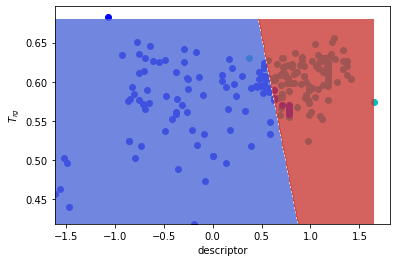

### SVM with non-linear kernel

We want to now use a SVM with a non-linear kernel. Using the kernel trick, our SVM supports non-linear boundaries between classes.

Test different values of the regularization parameter $C$ and investigate its effect. Note that $C$ is inversely proportional to $\lambda$ in the lecture. Thus large $C$ means low regularization. Compare the non-linear classification with the linear SVC. Is the result improved? How does it compare for various $C$? Can we expect the model to generalize well for large $C$?

We will work on optimizing the value of $C$ in a later exercise, for now it is only important to note its effect.

In [ ]:
#Initialize the non-linear support vector classifier and train it with the training
#data. In addition to the regularization parameter, we need to now specify the kernel.

#Try both 'rbf' (Gaussian) and 'poly' (polynomial) kernels. For the polynomial kernel
#you need to set the polynomial degree with the keyword argument degree.

#The relevant documentation can be found here:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVM = None

#With this method we can return the mean accuracy of our predictions on the
#test set.
confidence = SVM.score(x_vals_test, y_vals_test)
print('confidence', confidence)

h = .005

Cu_x=xvalsCu[:,0]
Cu_y=xvalsCu[:,1]
Zr_x=xvalsZr[:,0]
Zr_y=xvalsZr[:,1]
x_min=np.min([np.min(Cu_x), np.min(Zr_x)])
x_max=np.max([np.max(Cu_x), np.max(Zr_x)])
y_max=np.max([np.max(Cu_y), np.max(Zr_y)])
y_min=np.min([np.min(Cu_y), np.min(Zr_y)])

#Here we plot the data set.
plt.scatter(Cu_x,Cu_y,color='c')
plt.scatter(Zr_x,Zr_y,color='b')

#In the following we use our model to make predictions all over feature space
#in order to plot the sub-spaces of the two classes.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.xlabel('descriptor')
plt.ylabel('$T_{rg}$')
plt.show()

If you did everything correctly your plot should look something like this. Note that the figure will depend on the regularization parameter C, the kernel and what training data has randomly been chosen.

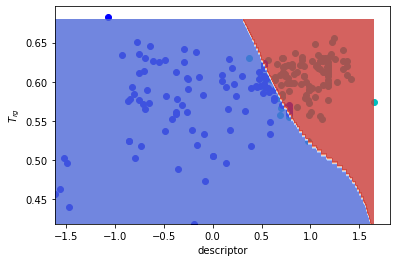

### Classification of 3 different majority elements

In the following we will extend our classification to 3 different classes of majority elements. For this we will include metal alloys in our investigation that have the majority element Lanthanum ('La').

First we need to extract the relevant data from the DataFrame.

In [ ]:
#In analogy to the previous exercises, initialize df_La_rows such that we can find all metal alloys, whose main elment is 'La'.
df_La_rows = None
#Initialize the DataFrame such that it contains only data with majority element iron.
df_La=None

df_classification_data_La=pd.DataFrame({'descriptor': df_La['NdValence_composition_average'], 'Trg': df_La['Trg']})

In [ ]:
#@title Check previous section
assert df_La.shape==(36, 23), "df_La does not have the correct shape."
print("Yay ! All tests successsfully passed.")

In [ ]:
lenLa=len(df_classification_data_La.index)
xvalsLa=np.transpose(np.array([df_classification_data_La['descriptor'][:], df_classification_data_La['Trg'][:]])).reshape(lenLa,2)
x_vals=np.concatenate([xvalsCu, xvalsZr, xvalsLa])

# it doesn't matter what label we assign to which class.
yvalsCu=np.ones(lenCu, dtype=np.integer)
yvalsZr=-np.ones(lenZr, dtype=np.integer)
yvalsLa=np.zeros(lenLa, dtype=np.integer)
y_vals=np.concatenate([yvalsCu, yvalsZr, yvalsLa])

x_vals_train, x_vals_test, y_vals_train, y_vals_test = train_test_split(x_vals, y_vals, test_size=0.2)

Now we want to train a non-linear SVM to classify our data.

In [ ]:
#Initialize the non-linear support vector classifier and train it with the training
#data. In addition to the regularization parameter, we need to now specify the kernel.
#Try both 'rbf' (Gaussian) and 'poly' (polynomial) kernels. For the polynomial kernel
#you need to set the polynomial degree with the keyword argument degree.
#The relevant documentation can be found here:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
SVM = None

#With this method we can return the mean accuracy of our predictions on the
#test set.
confidence = SVM.score(x_vals_test, y_vals_test)
print('confidence', confidence)

h = .005

#Generalize the following code for the SVM predictions and plots to the
#case of 3 classes.
Cu_x=xvalsCu[:,0]
Cu_y=xvalsCu[:,1]
Zr_x=xvalsZr[:,0]
Zr_y=xvalsZr[:,1]
x_min=np.min([np.min(Cu_x), np.min(Zr_x)])
x_max=np.max([np.max(Cu_x), np.max(Zr_x)])
y_max=np.max([np.max(Cu_y), np.max(Zr_y)])
y_min=np.min([np.min(Cu_y), np.min(Zr_y)])

#Here we plot the data set.
plt.scatter(Cu_x,Cu_y,color='c')
plt.scatter(Zr_x,Zr_y,color='b')

#In the following we use our model to make predictions all over feature space
#in order to plot the sub-spaces of the two classes.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.xlabel('descriptor')
plt.ylabel('$T_{rg}$')
plt.show()

If you did everything correctly your plot should look something like this. Note that the figure will depend on the regularization parameter C, the kernel and what training data has randomly been chosen.

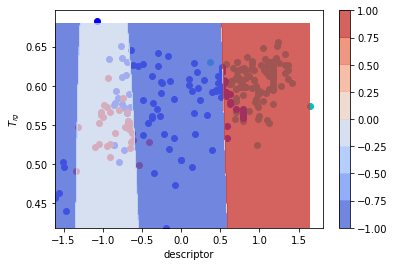

### Cross-validation for determining the regularization Parameter

So far we did not use any robust algorithm to determine the hyperparameter $C$ and the optimal kernel. Implement the cross-validation grid search, as it was used in the Kernel Ridge Regression exercise and determine the optimal value of $C$ and the optimal kernel (compare polynomial ('poly') and Gaussian ('rbf') kernels).

With cross-validation, we optimize the hyperparameters using a specific training and validation data set. It might still be a good idea to increase regularization (small $C$), if our data set is relatively small and we are in danger of overfitting. With more regularization we might improve our models generalizability, even though we decrease its performance on the training/validation set.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search expects a list of options for the hyperparameter scan.
# Use the range function to generate an example list for C
C = None

cv_number = None
kernel = None

grid_search = None
#Write the code to train the model here! You can use the default scoring function,
#i.e. the scoring function does not need to be set in the grid search.

print("The best combinations of parameters are %s with a score of %0.3f on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))

y_vals_predicted = grid_search.predict(x_vals_test) # scikit-learn automatically takes the best combination of hyperparameters from grid search
y_diff=y_vals_test-y_vals_predicted
print('confidence', np.count_nonzero(y_diff==0)/y_diff.size)

h = .005

#Generalize the following code for the SVM predictions and plots to the
#case of 3 classes.
Cu_x=xvalsCu[:,0]
Cu_y=xvalsCu[:,1]
Zr_x=xvalsZr[:,0]
Zr_y=xvalsZr[:,1]
La_x=xvalsLa[:,0]
La_y=xvalsLa[:,1]
x_min=np.min([np.min(Cu_x), np.min(Zr_x), np.min(La_x)])
x_max=np.max([np.max(Cu_x), np.max(Zr_x), np.max(La_x)])
y_max=np.max([np.max(Cu_y), np.max(Zr_y), np.max(La_y)])
y_min=np.min([np.min(Cu_y), np.min(Zr_y), np.min(La_y)])

#Here we plot the data set.
plt.scatter(Cu_x,Cu_y,color='c')
plt.scatter(Zr_x,Zr_y,color='b')
plt.scatter(La_x,La_y,color='r')

#In the following we use our model to make predictions all over feature space
#in order to plot the sub-spaces of the two classes.
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_search.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar()
plt.xlabel('descriptor')
plt.ylabel('$T_{rg}$')
plt.show()

If you did everything correctly, your plot should look something like this. Note that the figure will depend on the training data that has been randomly chosen.

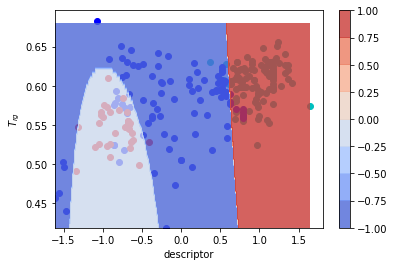

### Classification of high-dimensional data with PCA and SVM

In this exercise we want to use all Magpie descriptors and the $T_{rg}$ to improve our classification.

First do a Principle Component Analysis with two components and then classify the resulting data. Note that the $T_{rg}$ values are not standardized, i.e. the mean and standard deviation has not been subtracted. This has to be done first for the PCA to be meaningful.

Perform a grid search with cross validation to determine the optimal hyperparameters (gamma, $C$) for the Gaussian kernel ('rbf').

In [ ]:
#Write your solution here. For this you need to combine what you have learned in this and last week's exercise.

If you did everything correctly, your plot should look something like this. Note that the figure will depend on the training data that has been randomly chosen.

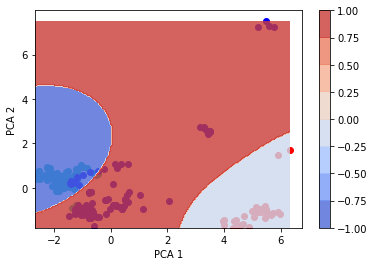